In [2]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
from Area2_analysis.funcs import nans
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

from pyglmnet import GLMCV, GLM
from scipy import stats



In [3]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
monkey = "Han_20171207"
filename = foldername + monkey + "_COactpas_TD.nwb"

dataset = NWBDataset(filename, split_heldout=False)
xy_vel = dataset.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])

bin_width = dataset.bin_width
print(bin_width)

1


In [4]:
active_mask = (~dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
all_mask = (dataset.trial_info.split != 'none')

n_neurons = dataset.data.spikes.shape[1]
print(n_neurons,'neurons')

153 neurons


In [5]:
#make dictionary for trial condition (reaching directions) for Stratified CV
trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == False) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == True) & \
           (dataset.trial_info['split'] != 'none'))[0])


active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

245 active trials
218 passive trials
[6. 4. 5. 4. 0. 2. 0. 5. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2.
 2. 7. 0. 4. 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2.
 1. 5. 1. 1. 1. 1. 1. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 6. 7. 2. 0. 0. 5. 7. 5. 1. 4. 2. 0. 0. 5.
 4. 6. 3. 6. 3. 6. 3. 1. 7. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5. 1.
 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0. 2.
 5. 1. 3. 0. 7. 2. 3. 1. 2. 2. 0. 4. 2. 1. 3. 5. 5. 2. 1. 4. 1. 1. 6. 4.
 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0. 0. 0. 3. 7.
 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4. 3. 3. 6. 1.
 0. 2. 0. 0. 3.]
245
[6. 3. 3. 2. 4. 0. 6. 1. 0. 3. 2. 7. 6. 6. 6. 5. 4. 5. 3. 0. 4. 1. 6. 6.
 1. 5. 1. 0. 7. 1. 4. 4. 7. 6. 7. 3. 3. 0. 3. 5. 6. 6. 3. 2. 1. 1. 4. 7.
 5. 4. 4. 4. 7. 4. 3. 0. 7. 0. 0. 0. 7. 2. 5. 3. 5. 2. 7. 2. 5. 7.

### Pyglmnet package

In [6]:
def process_train_test(X,y,training_set,test_set,cond_dict):
    """ Returns trial-averaged X_train, X_test, y_train, y_test, tailored for the data in trial structure """
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]
    #flat by trials
    X_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_train= y_train.reshape(y_train.shape[0]*y_train.shape[1])
    y_test= y_test.reshape(y_test.shape[0]*y_test.shape[1])

    X_train_mean = np.nanmean(X_train,axis=0)
    X_train_std = np.nanstd(X_train,axis=0)  
    X_train_std[X_train_std==0] = 1

    X_train = (X_train - X_train_mean)/X_train_std
    X_test = (X_test - X_train_mean)/X_train_std
    return X_train, X_test, y_train, y_test

def logL(y,y_hat):
    """Log likelihood"""
    eps = np.spacing(1)
    if isinstance(y_hat, (np.floating, float)):
        logL = np.sum(y * np.log(y_hat + eps) - y_hat)
    else:
        y_hat = [i + eps for i in y_hat]
        logL = np.sum(y * np.log(y_hat) - y_hat)
    return logL

def pseudo_R2(y, yhat, ynull):
    """Pseudo-R2 metric.

    Parameters
    ----------
    y : array
        Target labels of shape (n_samples, )

    yhat : array
        Predicted labels of shape (n_samples, )

    ynull_ : float
        Mean of the target labels (null model prediction)

    Returns
    -------
    score : float
        Pseudo-R2 score.
    """
    LS = logL(y, y)
    L0 = logL(y, ynull)
    L1 = logL(y, yhat)
    score = (1 - (LS - L1) / (LS - L0))
    return score        

In [7]:
def resample(data_array:np.array, encoding_bin_size:int):
    n_timepoints, n_features = data_array.shape
    resampled_data = nans((int(n_timepoints/encoding_bin_size),n_features))
    for i in range(n_features):
        current_feature = data_array[:,i]
        resampled_data[:,i] = np.mean(current_feature.reshape(-1,encoding_bin_size),axis=1).flatten()
    return resampled_data

In [16]:
#GLM params
distr = 'poisson'
random_state = 0
score_metric = 'pseudo_R2'

#Data selection params
align_range = (0,120)
lag_range = np.arange(-200,201,40)
encoding_bin_size = int(40)

active_behav_df = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~active_mask)
active_spikes_resampled = resample(active_behav_df.spikes.to_numpy(),encoding_bin_size)*1000 
active_behav = np.concatenate((active_behav_df['hand_pos'].to_numpy(),active_behav_df['hand_vel'].to_numpy(),active_behav_df['hand_acc'].to_numpy()),axis=1)
active_behav_resampled = resample(active_behav,encoding_bin_size)

passive_behav_df = dataset.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~passive_mask)
passive_spikes_resampled = resample(passive_behav_df.spikes.to_numpy(),encoding_bin_size)*1000
passive_behav = np.concatenate((passive_behav_df['hand_pos'].to_numpy(),passive_behav_df['hand_vel'].to_numpy(),passive_behav_df['hand_acc'].to_numpy()),axis=1)
passive_behav_resampled = resample(passive_behav,encoding_bin_size)

neuron_filter = np.logical_and(np.mean(active_spikes_resampled,axis = 0) > 1, np.mean(passive_spikes_resampled,axis = 0) > 1)
n_high_neurons = np.sum(neuron_filter)
print(n_high_neurons,'high fr neurons')

#Active
n_timepoints = int((align_range[1] - align_range[0])/encoding_bin_size)
n_cond = len(np.unique(active_cond_dict))
print(active_n_trials,'active trials')
print(n_timepoints,'timepoints')
print(n_cond,'conditions')

X_reshaped = active_behav_resampled.reshape(active_n_trials, n_timepoints, -1)

active_pR2 = nans([len(lag_range),n_high_neurons])
active_true = nans([len(lag_range),n_high_neurons,active_n_trials*n_timepoints])
active_pred = nans([len(lag_range),n_high_neurons,active_n_trials*n_timepoints])

i_lag = 0
for lag in lag_range:
    lag_align_range = (align_range[0] + lag, align_range[1] + lag) #lag neural activity
    rates_df = dataset.make_trial_data(align_field='move_onset_time', align_range=lag_align_range, ignored_trials=~active_mask)
    spikes = rates_df['spikes'].to_numpy()[:,neuron_filter] #spikes.shape = (T,num_neurons)
    spikes_resampled = resample(spikes,encoding_bin_size)*1000
    j_idx = 0
    for nrn_idx in range(n_high_neurons):
        curr_spike = spikes_resampled[:,nrn_idx] #take a neuron
        glm = GLMCV(distr=distr, cv=3, score_metric=score_metric, random_state = random_state, verbose=False)
        pred_spike = glm.fit_predict(stats.zscore(active_behav_resampled,axis=0),curr_spike)
        active_true[i_lag,j_idx,:] = curr_spike
        active_pred[i_lag,j_idx,:] = pred_spike
        pR2 = pseudo_R2(curr_spike,pred_spike,np.mean(curr_spike))
        print(pR2)
        # Cross valiadate R2
        y_reshaped = curr_spike.reshape(active_n_trials, n_timepoints,1)
        n_splits = 5
        skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state = 42)   
        true_concat = nans([active_n_trials*n_timepoints])
        pred_concat = nans([active_n_trials*n_timepoints])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,active_n_trials),active_cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X_reshaped,y_reshaped,training_set,test_set,active_cond_dict) 
            glm = GLMCV(distr=distr, cv=3, score_metric=score_metric, random_state = random_state, verbose=False)
            glm.fit(X_train, y_train)
            y_test_predicted = glm.predict(X_test)

            n = len(y_test)
            true_concat[trial_save_idx:trial_save_idx+n] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n] = y_test_predicted
            trial_save_idx += n     
        pR2 = pseudo_R2(true_concat,pred_concat,np.mean(true_concat))
        print(pR2)
        active_pR2[i_lag,j_idx] = pR2       
        j_idx+=1
    i_lag+=1


#Passive
n_cond = len(np.unique(passive_cond_dict))
print(passive_n_trials,'passive trials')
print(n_timepoints,'timepoints')
print(n_cond,'conditions')

X_reshaped = passive_behav_resampled.reshape(passive_n_trials, n_timepoints, -1)

passive_pR2 = nans([len(lag_range),n_high_neurons])
passive_true = nans([len(lag_range),n_high_neurons,passive_n_trials*n_timepoints])
passive_pred = nans([len(lag_range),n_high_neurons,passive_n_trials*n_timepoints])

i_lag = 0
for lag in lag_range:
    lag_align_range = (align_range[0] + lag, align_range[1] + lag) #lag neural activity
    rates_df = dataset.make_trial_data(align_field='move_onset_time', align_range=lag_align_range, ignored_trials=~passive_mask)
    spikes = rates_df['spikes'].to_numpy()[:,neuron_filter] #spikes.shape = (T,num_neurons)
    spikes_resampled = resample(spikes,encoding_bin_size)*1000
    j_idx = 0
    for nrn_idx in range(n_high_neurons):
        curr_spike = spikes_resampled[:,nrn_idx] #take a neuron
        glm = GLMCV(distr=distr, cv=3,score_metric=score_metric, random_state = random_state, verbose=False)
        pred_spike = glm.fit_predict(stats.zscore(passive_behav_resampled,axis=0),curr_spike)
        passive_true[i_lag,j_idx,:] = curr_spike
        passive_pred[i_lag,j_idx,:] = pred_spike
        pR2 = pseudo_R2(curr_spike,pred_spike,np.mean(curr_spike))
        print(pR2)
        passive_pR2[i_lag,j_idx] = pR2 

        # Cross valiadate R2
        y_reshaped = curr_spike.reshape(passive_n_trials, n_timepoints,1)
        n_splits = 5
        skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state = 42)   
        true_concat = nans([passive_n_trials*n_timepoints])
        pred_concat = nans([passive_n_trials*n_timepoints])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,passive_n_trials),passive_cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X_reshaped,y_reshaped,training_set,test_set,passive_cond_dict) 
            glm = GLMCV(distr=distr, cv=3, score_metric=score_metric, random_state = random_state, verbose=False)
            glm.fit(X_train, y_train)
            y_test_predicted = glm.predict(X_test)

            n = len(y_test)
            true_concat[trial_save_idx:trial_save_idx+n] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n] = y_test_predicted
            trial_save_idx += n     
        pR2 = pseudo_R2(true_concat,pred_concat,np.mean(true_concat))
        print(pR2)
        passive_pR2[i_lag,j_idx] = pR2
        
        j_idx+=1
    i_lag+=1

125 high fr neurons
245 active trials
3 timepoints
8 conditions


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-5.972999872483342e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008515736770897453
-5.10702591327572e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01108487350864018
0.0159474524040355


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002306162470082196
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010335085375750008
-1.509903313490213e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00411985733420317
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005186935595347109
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015484805096113163
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015017718757401877
-1.5543122344752192e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006536429932728849
4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003457212079838179
-8.43769498715119e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004076232171467797
-5.329070518200751e-15
-0.010243099777584197
0.003383636940383905
-0.0012087337805060105


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0026505724700955913
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017361720675461711
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004363755104539679
-8.748557434046234e-14
-0.002023324791704084
-5.10702591327572e-15
-0.002451165133094735
-1.5543122344752192e-15
-0.007142583174048145


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008711622780217976
-1.4654943925052066e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0041632884379385615
0.005828446442707524


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00029004628901141416
-2.4424906541753444e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0031889530532362986
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02661048636508978
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009541184666421065
0.06929445874884499


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.041920390447088396
1.9984014443252818e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030454586501584835
0.0005619454099297094


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0047500834792271185
0.00485911045182541


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00805018058819229
0.004112569504666874


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013097585867929418
0.005563995652417941
-0.0032077813665449817


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006980483242067126


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006343651085701119
-3.552713678800501e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015535534217232527
-9.9253938401489e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015220827895324973
0.003113070083690772
-0.01016890757241029
-1.4439560658274786e-12
-0.006127491945933317


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010849439318985188


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01719997070273238
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0004436130233795854
0.0014306341599606975


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0007169820086526668
0.01448377469032347


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00854430874587453
-7.327471962526033e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036540948995504863
0.012498565767996572


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00017187485404024372
-9.341416529196067e-13
-0.011878263037157444
0.0004389552271089059


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0046659636556976025
1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005502563690737761
-9.103828801926284e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02327075371981735
-1.9539925233402755e-14
-0.0016630347299126935
-2.6645352591003757e-15
-0.005625239173170815


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0024211684074677553
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.000787105104228969
-9.547918011776346e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009512257577697358
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003092223253340798
-4.218847493575595e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001921305160356157
0.006040824723717475


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00039545246854011395
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0063662686996510676
0.009729547426922558
-0.005999439741642076


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0055995566747688574
0.014794271770050105


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00956867907029424
-9.792167077193881e-14
-0.0032497514363030167


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-7.815970093361102e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004205293293964019
0.00583020150454594


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032309027468699902
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008622061015882032
0.0008176013901278756


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013408721189682726
-1.1102230246251565e-15
-0.011496861031107919


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0045117192321126875


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019004991529058435
0.006250315082227398


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0077370525630893194
-2.6645352591003757e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030924763170625535
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038588390893559144
0.010304043781938055


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.002901251662101312
0.045328304916514184
-0.013251327358179354
0.020753819318597655


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014108262053948106
-1.9984014443252818e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01586892057428857
-1.3322676295501878e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014611143182049702
-1.2234657731369225e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00740373332626465
3.3306690738754696e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005154889335332591
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007156038073998339
-2.779998453661392e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009984480615185198
0.0063778778451040186


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008026371418583311
0.00482083497236907


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0031308018542830496
-1.3100631690576847e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005266230594124233
0.0031822177552719433


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002705905792420138
-1.341149413747189e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02817540803635543
1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02457532119112127
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008139875860670331
-8.570921750106208e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00199944003932484
-1.184163878065192e-12
-0.0012762183518129078
-1.1457501614131615e-13
-0.006791719763445503


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-7.545075675352564e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00477003946789778
-7.993605777301127e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030228330780519563
-1.9095836023552692e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006763695440860085
0.00995644085754166


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004845151742317033
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03472024235691462
0.004532500221587243


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03814370310438364
0.004535433367045427


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004454841547065769
-2.8591846246150965e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005390213232247643
0.07847962568067302


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002513951270582071
-1.0658141036401503e-14
-0.027407065667526487


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.861178292183467e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004931500103434239
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015465124042738587
-8.881784197001252e-16
-0.011243635845964217
0.024088792706549955
-0.029162071614776908


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005331058679591605
0.012808831894653872


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0010937393778169824
-4.440892098500626e-16
-0.006520040929720583
-5.329070518200751e-15
-0.0074408581459874945


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01321245582301911
0.029774775590822422


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06953602073708187
-1.176836406102666e-14
-0.011533790630028795
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04731395916667447
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003671959769518285
-6.8833827526759706e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009209040553837866
-1.1102230246251565e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00788147452920418
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004416696130207454
0.004912746725130868


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012641227325157045
0.00885239682061012


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010074749603683708
-6.8833827526759706e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002623223017560905
0.0
-0.008719717059480159


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.008317635099190257


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011070947689380661
-1.2434497875801753e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005167414146840743
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004138659979215031
0.0016889005518906375


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00711089341700788
-2.398081733190338e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001195023259923822
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002205595092361623
0.012689321089908279


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003316938247914236
-9.325873406851315e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016071861193318604


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004591711129114051


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014630647939402053
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009612387670477007
-0.08982532780596397


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0034858637658414793
-7.327471962526033e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.029960562135049162
-1.2244958689233698e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002419139479948207
0.0020764996170392624


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005985377357118349
0.02860737779408573


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009132902498272144
0.0009437670418421806


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003605503604694249
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011313066457379284
0.0037924215569286046


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009803459262332614
0.00684466765428926


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012079436039333702
-1.1102230246251565e-14
-0.01794969090926668
0.0
-0.006166690841427291


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.8191672047105385e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0056227282750049845
-9.325873406851315e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0029742235196164035
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004018845931073933
-9.725553695716371e-14
-0.0032404305025348634
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007460791984069681
-2.6645352591003757e-15
-0.010092183363266338


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005976455343813525
-4.3298697960381105e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002191640215945645
-1.9761969838327786e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0035079883493063235
0.0001118340277458385


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004433188328996307
0.020209322633824134


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0011102899995298898
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.020023118945222684
-8.149037000748649e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01143122292320542
-7.194245199571014e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0035530795312159746
-6.794564910705958e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013298130950534226
0.001112313487884653


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007582558887663238
0.04074919846017999


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0241133920920249
-8.215650382226158e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011031677608741575
-3.552713678800501e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022792631381565176
-3.9968028886505635e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032192884356028184
0.00528106223936553


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.024955100059822266
-1.1324274851176597e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009058791172732228
0.013645015084165601
-0.007638805614077704


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04556060173678522


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03735821039235565
0.006872622769400483


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0008191358760222256
-7.027679874327397e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002166513800130998
0.007700521070618804


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001383742787996134
0.0069627462496425485


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002805369075239872
-1.7763568394002505e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004623854590500409
0.01002797485548168
-0.0036338300113358812


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009457157055636323


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009406994216363707
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005544768875985762
0.03892845046434945


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023180817233264817
-2.6423307986078726e-14
-0.0013883011529878253
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004000773663372703
-1.2656542480726785e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00337180313328056
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003556540752376991
-5.1514348342607263e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022502448651604556
-2.1760371282653068e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005262634396788091
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001350373562077234
0.009617063376243906


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0039495044580855065
0.011592937279147564


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006377883049993427
-6.88338275267597e-14
-0.002877868465736677


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009792578532803908
0.007357612088881416


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005445491985389461
-1.709743457922741e-14
-0.0013324522748581202


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.885780586188048e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0059664753979977725
-1.1324274851176597e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008531339877823951
-1.9984014443252818e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01203748427890794
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005828783279093308
-1.3922196728799463e-13
-0.007323304225764549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019063566910699326
0.08800564143351464


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03362093541265432
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004750611905068647
1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013788711298117873
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0004389527958739148
-7.549516567451064e-15
-0.0035256427728951323
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.020824203985635892
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005140432220687607
0.007394048436675349


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007912509562310488
-2.220446049250313e-16
-0.004163740971704355


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.328271240363392e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005334200725575222
-2.19824158875781e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0019228500109864655
0.05943356598059801


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.05298501941470546
0.012034007587814477


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007470257258045843
0.016192491259291897


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014494270851213131
-3.552713678800501e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003765112927484271
-3.9745984281580604e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038444627103226825
0.04829810575881377


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004389188977933833
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003909969931749524
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00493086304298207
-3.019806626980426e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021147634678999605
-1.1188827642172328e-12
-0.0013790353558786883
-7.105427357601002e-15
-0.003299345294691447


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.086242620995108e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010661741105285838
-4.218847493575595e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02529295958823008
-2.886579864025407e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001499235287764522
-1.056932319443149e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004935323592663021
-1.3322676295501878e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01796315226424139
0.05891439940313481
-0.010662810482602536


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013078918699577002
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012984638568007245
-2.7977620220553945e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.024025873938797e-05
-1.0880185641326534e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.021046192015537146
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032651950656159556
0.0013184714143337217


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.017837209013928046
0.015643846051754284


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.030471591678582044
0.06455166087965025


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.025263057398554833
0.007486794627471038


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01886593356418298
-5.129230373768223e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009722832513188395
0.008202557259389454
-0.017022863854667225
0.00248930995764729
-0.008743822366313214


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01601211151699089
0.03258671116052636


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019428461664492414
-1.554312234475219e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007214972586980561
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015769009511878984
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004141069925770013
-8.237854842718662e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003922138484958149
-1.4654943925052066e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003512656360303845
-1.3322676295501878e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005487731447840094
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00995591669377105
0.001991488780803574


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04337949050955592
0.0025334285972244963


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008992556253137884
0.04088109780733484


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006597319744162888
0.034077685574326666


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010746965335042713
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033556063773694245
0.0010112400083115425


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013640527060130303
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0002839816015469676
0.004293252323979924


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010467309500884925
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013748821593397853
0.013522054644181325


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0042000489479174785
-7.890532890031388e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016372579095047524


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011905972324927072


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017006606670224578
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.025199332047808554
0.07402995351384589


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05703858519525973
0.001304447859221014


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007855467973953978
0.001101238180240105


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005298201710867145
-1.9984014443252818e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006258280908468361
0.02799074446605121


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005959840449719533
0.005763903498136158


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008122041113269418
-0.0021064605319873753


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.020866674045299183
0.0017070828376863911


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0004146179892026147
0.008606857266757473


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033688037110715108
0.015791586271395097
-0.016148249114649627
0.019036378056935255
0.004475442101178673


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004178307854341479


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007748658061908609
-5.273221555635033e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0006745257939346772
0.0007113957803502879


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0023599302451298154
0.008113722207451879
-0.0002429777505679187
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015383855210999497
-4.6629367034256575e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012201960243600984
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003499498632347331
0.014547955755118025


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0042548005895752805
1.5475896924410648e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005175798911169149
0.0032550724035217415


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003219962207413163
0.01597254661096348


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011804084514234425
0.04633003479607867


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03274136350553736
0.02607881022132974


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011522597742415153
0.11200257830515103


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0994907549083649
-2.020605904817785e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


3.647465311673592e-05
0.07798829022936382


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06867746885935744
0.2109563765932292


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1999030450889956
0.051474559011912224


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03528094276215943
0.011620709330530277


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0023755699010963305
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006234971696724045
0.07517688006293344


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011146749463219252
0.02947459270888264
-0.019287069383709943
0.14585002384889023


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13083843838056208
0.2915751406218202
0.27883355223350026


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.439293542825908e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001198116862332732
0.0026880063737773074


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.028268143729084816
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036651731532790777
0.06695807054240954


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.024188491877644158
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010400446010288222
0.016406004988235967


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.008087195234127487
0.02676089898041334


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017082637010372714
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002819620984825466
-1.1102230246251565e-14
-0.003220816204107857
-1.1102230246251565e-15
-0.0005603160276939079
2.220446049250313e-16
-0.0041247457613635685


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.951594689828198e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004070636644509795
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005582340655369222
-3.1308289294429414e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016825971062681688
0.004387125057221497


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014071025249751123
-4.884981308350689e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010667874683287781
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007182953136266823
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010313415432621653
0.006545958344208569
-0.005893626144602093


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005501615738799925


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003951190634183588
-7.327471962526033e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010700603025761701
0.011807578715973488
0.003035975168607985


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004647753346764372
-8.415490526658687e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015567607078727397
0.011139870681750264


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0023331469905809588
-6.8833827526759706e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008470374352311794
0.04068931825586619
-0.02242915856624883


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011313971533524758


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002760843943396818
0.032626245938156884


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0042893205604198625
-2.042810365310288e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001538501150376126
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0018730354826570483
0.0015374107515041535


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0007234097255881533
0.016052254706498403


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.024150869851619072
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014671207344533865
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011190559636329978
0.019901561649995347


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003964778307471439
-1.1102230246251565e-15
-0.01151116188915613


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.037222671156371456


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02760961755774083
0.0003014693232620269


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00229733188249992
0.03692125559113435


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03872194065683532
-1.3100631690576847e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004428727182953729
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0004722724747430185
0.012148680039927084


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017512274141910922
0.008143223516284825


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023125066738530986
0.19781021167844937


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17542217843792707
0.007636582860983565


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0031822060823032405
0.02962263357210082


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.026872617201328053
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0019528201090563968
0.01095350003109552
-0.0032998238633299426
-3.597122599785507e-14
-0.0011346357984785005
0.02359381040889308


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013904586975158839
0.011225035001874994


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0029655651833915275
0.0014728709733036194


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025802235083434155
0.0002860545114404811


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008902135292339075
-1.7985612998927536e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.020021032052901733
0.012648313782777754
-0.005149273313259872


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012535664127177437


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00871964791086155
-2.4868995751603507e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005682577121226551
0.02185957751136669


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033540159143765624
-5.46229728115577e-14
-0.011072687138617754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.419486915845482e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025989896172122773
-0.027655818512970054


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06802305339659842
0.008609433088469176
-0.016146373839215356


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017275699934172217


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019279175340037646
-5.5350369247975095e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013150494667368617
-0.0037087465290057686


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002364533186171913
-2.220446049250313e-16
-0.005817058470467762
-5.484501741648273e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023851207587201495
1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012474670058586046
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033267072995155633
-6.439293542825908e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00915770751756928
0.014183843882387137


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0252513065462856
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006521663047082127
-4.440892098500626e-15
-0.014817962231677306


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013629159515509137
0.007220332942588059


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0049171663560443335
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0035730971822360846
-3.1086244689504383e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011114837303473069
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002852881681078001
0.027896188210204675
-0.027434536217017635


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05753700554789398


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03983205869168105
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002090908688349602
-2.6645352591003757e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007457683631233447
0.0018549776631371362


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006798400935095872
0.005605369430173646


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.000998028106939941
0.00888884436613846


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0011849892945678953
0.03847663824582348


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.024900324436332943
-2.2973238878565283e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010898999778499396
0.045647604790378105


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01534002737056328
-9.547918011776346e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00380845006316477
0.14874480966630566


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11641153425510864
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003541966426017673
-2.0650148258027912e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007128928782333732
-4.9031017070877425e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003359426554044642
0.003563914201826668


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0035601728769922847
0.06010803214446392


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004783182194713964
0.14204794408437715


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09062516706844659
-1.122737503189697e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004013211198450772
0.008705208380441642


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0012338615650755447
0.0
-0.007294613310846021


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06403206403082784


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04871913915481474
0.11522783400481029


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01448032402440469
-0.00017102714288808052


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016950317446553842
0.0024061808210761315


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017057851262261003
0.025022081233103455
0.018162329809572553


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.026441963700872484


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00523872783800039
-1.5543122344752192e-15
-0.010590167267025441


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0176422039913805


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.002876430765327287
0.08067743968125574


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06622922734156467
-0.03059072173032562


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02498352392875658
-0.029558199822211195


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.05777199048331094
0.002918503229451308


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00332343443663774
-0.0074261603913228225


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04176043538210017
0.04700963254909407


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010324394356953204
0.19958921527548257


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18302610206282055
0.011793881829963548


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001115861465539325
0.1457260918486475


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1117289745287281
0.38486883017861684
0.376557460701624


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19821114243530424


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18700794677027532
0.005551994149214479


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0002502216905077015
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003949181587367567
-4.8405723873656825e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.027211226259954646
0.03345395333643297


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010036229691516407
0.3408758832990729
0.3301962383815751
0.557411548908282
0.546327517155397


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


3.3306690738754696e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003706681527964717
0.005269332111354164


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.045993448761957545
0.001046730117020056


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002694218298233686
0.15129062688057549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1431606655440908
0.006758487015206427


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.002508612586577752
0.022384572716113382


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011311737198164917
0.02847993725267417
0.011473377920894978


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.10696836333566462


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.12000824087786688
0.016795553666096197
-0.013535204730033668
0.006858282248349057
0.0006593208397069894
0.0005551222003380429
-0.005198378072711618


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0017010849744996115


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001502512157937952
0.0028542919997995853


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0046261583478557355
0.011160699568049326


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0030154229349946826
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0018614491846815628
0.01359022139501287


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001897200245216446
-3.197442310920451e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00717236107263064
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005216206874009588
0.062179397714639095
0.053036355471352215


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.307564022536624e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00040030082929110034
0.005299741814660863


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0042972563577208245
0.03759380596384099
0.026891792033266415


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006657202893004088


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0008951420313026981
0.0004430476678044526


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01052455966486443
0.016661185223602937


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011741952321061011
0.053554080343578114


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.039962769212744775
0.012417402755268814


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01307220752823568
0.017865701702373893


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032335970551520266
0.016493415213006624


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0017751794847931102
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017065390371806544
0.006138665797013387


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030726547017749795
0.05604469262545586


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.021925734627432636
0.037410701012859704


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004302517875167222
-0.02209330937475662


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0143578546735591
-5.750955267558311e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005577585053977652
0.02835639797385403


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015558778789888983
-3.1308289294429414e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012421128748159926
0.09208559064984734


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07801780490330523
-5.093493617658318e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016923832492634627
0.06161352039284074


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004109147048235284
0.0630991392684096


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04626251024259975
0.006166181169329765


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0031404091995332895
-8.607997112242138e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00043756011284412644
0.007187958225116309


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023419263754114406
0.3762324391982853


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.35130406417750104
0.08448419089221404


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02921747399323582
0.23347292571207612


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20573304206957543
0.003978555325373834


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002399253145671798
0.05048834812353753


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.028867062777473973
-1.2878587085651816e-14
-0.005981247070913742


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015176902974448958


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0053369022239133646
0.05213630144252124


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02116802419752606
0.013358340156063964


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010207270487210707
-0.018565979423739387


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.041914439309579166
0.028624962762088257


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011753752448165011
0.05957199308005301


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.021265313287344934
0.0010175651544761521


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03104978916391432
-2.531308496145357e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004190491139961505
-4.218847493575595e-15
-0.047969865327934125


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00591683117726205


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011636172119775301
0.029625208737957487


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.018346591038333582
0.001963377941082034


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022446418930284207
0.01466639413477111


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005462929625365653
-8.941736240331011e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02168854355871197
0.006621371170733914


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008174247536623547
0.020419459213807944


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010337350023377212
-7.593925488436071e-14
-0.00805242465295164
0.06740788130136521
-0.02563371922015123


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.042176290836225316


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03665031747185954
-0.00035148532263717946


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01986084523077447
0.05145928153651913
0.04099077680961116


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03659973387985216


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016292591221466646
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005397568816590814
0.03655901244466153


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001302167678265409
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006197925848172803
0.012173256074724192


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006045268502768764
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022801883651077937
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02211293480646548
0.016548963495457536


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002288095767230214
0.04646301799216368
-0.006506039689490262


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.053337723692168826


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07207976060166632
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015718915566265146
0.0009927573325970718


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004940024398189413
0.00678270980888207


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016595917334356614
0.015244161049088323


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006566040017682462
0.040129034307833544


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002363617160399567
-0.07894053493563669


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.07589071652302071
0.0669570679879593


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.051833755321472164


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0330353532886718


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02213851689244839
-1.2878587085651816e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004014360547123896
0.1264437742070964


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10836179905145893
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019506526218458164
-2.5091040356528538e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014090334299661222
-1.1182252581676266e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0008624724593403466
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0007279750599451518
0.07020794054872359


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.030830476925237882
0.139569657190168


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05643450061194899
0.0035547400518015637


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0019098360448102092
-0.3336293931115497


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.20414981443528935
0.004412161900334555
-0.008945067511862304


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05690300531980563


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.042068188015271346
0.16850169299280615


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1427462676642416
0.18302115190133872


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.175444185238967
0.018173833372660764


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010765975554549723
0.060627970997384595


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04080345607734004
0.024907380551886682


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009836626906743251
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0029643641695884515
0.017930116482453462


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006824039614480748
0.14262251238367452


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13126982658204966
0.005838011511340002


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008174649351959662
-0.26128954608818566


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.20106421047230527
0.0016434108111176293


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0002830696505204955
-0.019204287276872734


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.026639840451010866
0.16627450303057467


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14946738096121226
0.2578524187201485


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23268073138985068
0.04568123983282102


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01765819821295611
0.2497223539273492


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23831403158709508
0.3876252222695452
0.3765736884369748


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2763581432450294


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2680739167139783
0.0019948756509365895


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0007601270732253695
0.017272666147380877


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006006262031498677
-9.325873406851315e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01683263808050839
-0.0019703970475444255


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008854842505710447
0.4187943953960873
0.3978445854439322
0.685660541476999
0.6789712457101387


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0052681644410307316


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013574618923626325
0.003097216408950665


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.025047198813483273
-9.486945678371939e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00256543814858623
0.15992470111100265


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1655688287890198
0.05425564990675413


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.036671809375597775
0.020534080765889806


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0003940660340171487
-3.9745984281580604e-14
-0.006603974606849583


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00010604264492297677


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003054194714688041
0.007001756119555669
-0.02259584287237404
0.01583118527445404
0.00651956280192878
0.002614681513727568
-0.012870521847227145


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.9405226476365556e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02159706113925486
0.0007053952727771318


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017118235524153924
0.01970990656731275


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017979391365672281
-2.442884066700124e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013156955993052666
0.018423888996808246


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01199480868720404
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00972698970290753
0.006106031905722231


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033807643535952447
0.21098336378707316


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20107107696013504
0.025985264511072526


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014117838156570084
0.007054248159873877


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0037577313675472013
0.03732863211264337
0.03758952718554809


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007186863827567058


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016248903276414928
-1.0880185641326534e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008347843248057929
0.0021570007898485954


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.033745398135112126
0.05542377936241527


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02991111910825195
0.038156810531061014


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.035628448072683616
0.029610743788958116


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003757384440828182
0.012544165661463436


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0050429599873296205
0.006244815027924511


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005579018208846653
0.02867947308721197


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014642350672539828
0.05838412150681482


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0523536501094608
0.014449285446853644


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03807393911412693
-0.004256063458163872


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013954140920459102
0.017090569786068377


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0031145453219685315
0.05775219556597133


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.020079493634909573
0.005916226754629217


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008366024266883043
0.18985823924156475


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17405293644498232
0.17237932617784246


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14969545601432455
0.06939966123312302


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.020271644196863114
0.119831331161658


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08688580339965435
-0.013357482555739209


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03247054634333724
0.00146031291993165


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009424774678443715
0.0072065339091959


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009663625286487676
0.5202296311861379


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.49980831034715667
0.17216488842459654


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1608271169614678
0.3367476197895435


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.30686390368066463
0.026814144961990305


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02491219055757865
0.0784911091420718


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06393488730565189
0.0275838199385684


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01542871598322093
0.019948608575249827


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0003548144409397658
0.0694321430749022


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05580881718832653
0.002601388868748722


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010448830787786134
0.07284294861704954


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0511241146510546
0.010324223852046899


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03704049429937695
-9.348077867343818e-14
-0.006550313622900372


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012180944857585141


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010991616545427352
0.06674377457115777


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.029177304693671968
-1.2434497875801753e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007531248509138333
0.005230139324839178


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.021780854599000365
0.019503994446757766
-0.005648284099996959


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07413556221669892


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.057432344264192636
0.018177417792515693


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.024077090996473927
-2.7822188997106423e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.027891912488843484
-7.327471962526033e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018664115588139962
1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.020606355041613567
0.030678168173259968
-0.006842081007093936
0.04366068453235483
0.001979573807919466


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.022579240064561024


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.08832346657838608
0.030673437873851017


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016492484027551657
0.10735428822650106
0.05141059290084515


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009880448151178278


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009857845352218009
0.007315524320702593


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00909095419439443
0.09098077638642332


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.043437580464078085
0.011258992419598046


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02046158216272942
-8.881784197001252e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006050299313128393
0.02537251728743095


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012095124168974958
-0.027451185442106674


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06026026979032517
0.003672949447218188


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.07623860029653429
0.021123976765056507
-0.009936252309229898


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.002783792304484334


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.042109559861466916
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00033950701153506735
0.012921818199524204


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00849962380408198
0.03835580759603674


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004838939823538224
0.004493249021120804


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015371752794814952
0.051389786404606674


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.037043472614949446
0.04644523200364481


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.123236469204562
0.18141030089162014


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16876056398553452


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0752068144133714


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04065002893301106
0.07771592764423774
0.03890086982375096
0.08141925678678208
0.06840032029111986


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-9.769962616701378e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016996299771234957
-4.418687638008123e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036411031863861076
0.055454960230004846


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.038013081460296694
0.0055608188488537325


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004155300023305442
0.026832487793062465


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.049936502560045004
-0.09651807671082735


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.1243165918437028
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0006884250245371426
0.03300436021847897


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.008645525684171984
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016037861107432327
0.07129245952788044


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.061669068107179315
0.18486852651675623


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1570184509978354
0.256868413110274
0.23785890138599464


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013773375063297011


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012084682793441881
0.10179892433238746


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08240246031093879
0.020652795151240744


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006695236340561683
0.043536633684919


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04768768266074275
0.05876360919686252


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009189030041105273
0.1920355188839219


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1824700934093293
0.09075981863799942


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07880684702674723
-0.08823207865501437


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015606321313000993
0.011887105463985637


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.000857836465994577
0.05572265883509908


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05865613954205706
0.17536350991010607


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1536570244471317
0.26832661288992843


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2538595227767052
0.11558551822682328


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04601448731783819
0.3172687075362324


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.29923683561690717
0.3023841844265073
0.28641795887677257
0.3174580685725521


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.29448270789665265
-2.5979218776228663e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004587696196026947
-0.001976010373935244


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0070870953077533105
0.016914267238123726
-0.011756094175673804


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009411442178270946


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028824509187435066
0.372686054144159


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.332533665879561
0.6943152716488987


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.6877594779505967
0.04173765992551426


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009210466003163775
-3.3306690738754696e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015330190580678416
0.0126759417766662


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010059113458709135
0.11289782201100096


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11863555676591697
0.11180968169008876
0.09720810356202159


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014752713676394968


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00480967911927499
0.04062215919501866
0.024456554366046768


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009861612645635676


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006226986065249851
-9.547918011776346e-15
-0.033618516785507424
-1.2359002710127243e-12


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0015357355146592422
-1.3322676295501878e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013779242735214803
-7.182372327396713e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005000441916865772
0.00361213633853974


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0020055203747284533
0.055704919369568784


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04374865165698949
-0.00022236976478295922


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0043970892433153885
0.015301551100439625
0.011291585054383324
-1.5543122344752192e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0050442107591843754
0.021925000140251005
0.003117947201252358


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3232856559475361


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3091204027992077
0.05472468372293593


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007908100356927572
-6.439293542825908e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00233059264567248
0.06799397547393915
0.054957169085523505


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004032165648213404


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004006201899817929
-2.2870594307278225e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016921668907194265
0.11532459123229566


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07956088487698276
-0.16410376000234628


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02325653595891919
0.02145438624415763
-0.04253144569445322
0.05602175781760954


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009669068163797201
0.028150248045106907
-0.005413958071443181


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013757674790319308


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0018687043589933339
0.08218007150273032


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05976055030071592
0.03349774694510943


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017012383170157408
0.18461777985658


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17018394465379383
-0.00853895258626558


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018219039913342172
0.03838650245880726


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02206423098769661
-1.4366285938649526e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004665670505748842
0.0001497771643247381


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003405881062733762
0.23093602315602413


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21253646240480595
0.3808269588531663
0.35427792275503245
0.07109346731531152
0.010729314299247505


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17631969357469612


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15885676627278977
-0.02234650841341823


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06316142669781244
0.00028081248609401754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003233525319065844
0.05438238375575588


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.043929928588673395
0.5279578036881099


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.5076583260110423
0.16095424101940625


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16200326742327853
0.31757250506508483


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2974610283331215
0.08470721404257331


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05241287325862587
0.22210398884277738


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2089245809461151
0.09193118283527135


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08080023735993525
-0.00040794759656814783


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013057513582330538
0.09604383630766489


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08056804826161157
-2.708944180085382e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0026941665829387507
0.10337558005762904


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1070376168875451
-0.000686487986237605


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001291252683804145
0.06401209284622578


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006812990872360092
-1.4210854715202004e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02468672733949706
0.10233576252531273


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09645653894389028
-7.549516567451064e-15
-0.00942523168510978


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015465482814616571


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005210720310803274
0.019575779491015632
0.005353798178184155


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09469778461569145


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.079492817428084
0.007751611250032431


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007638381915033632
0.046006691831821156


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011759894975773344
0.020885879753567704


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005627943576825389
0.009220446120762782


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04600834172794066
0.04855690380528732
-0.0433729418174531


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00838197917019623
0.04504415033103559


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.037394120338979486
0.04505883798985866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03516163305700171
0.08171737350035346


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04591556587570633
-0.016956802727489118


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004968396312326373
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010391127988591098
-0.01950672091236827


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.025646723565394103
-0.0030341745539530507


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0612440387327613
-1.0769163338864018e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00961239096976807
0.06759164372524384


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.019079994962246993
-0.04026844960303033


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.05753792098588173
0.00840957772118911


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00661090435251066
-5.262457136723242e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009988025971868097
-0.04192852518876333


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.060117279172259286
-2.9976021664879227e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004842253410645814
0.04710661212142164


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03615454188419975
0.06517040810372698


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.049777879302518424
-2.6515196035914457e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004788084618821298
0.007242623169203544


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.050076602638615686
0.17805340587444318


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1762872026735074
0.25486242643063883


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2332969905956852


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11108816770667573


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09879513405991924
0.1496850676321655
0.11906391167144181
0.024232722517819938
0.009556861190618271


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01508289434763821
0.0023162028519868594


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002579402616015969
0.1854301282850921


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15850622247433055
0.01963984617009673


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0027752747476159634
0.04978150360593825


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03462483997681054
-0.25764015712496446


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.13093425646333867
0.0003903757337079261


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0007743570678968581
0.0568226988353695


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0436372393886123
0.04370166731511771


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0011123856809656107
0.10743294824897542


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07751922017150537
0.14118320518096106


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11119579113113076
0.23535514180916572
0.2224044858722244


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01496752418924352


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.017849034859051205
0.13589347443936461


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12245425157509504
0.04535498161453333


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0407746067340059
0.005554792199804037


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0415229970908213
0.02193233523248339


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.035407577303976034
0.16640673777721426


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14862348895301347
0.020773481338011934


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04303209522611895
0.061675719672564244


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0033485291403270168
0.027306582476842034


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013527729018103396
0.047020079330609366


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04304176306477181
0.14402693573398284


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09110780820181397
0.0726492005959265


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.043834994338339595
-0.014847748009942707


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06588013225751554
0.278127697821401


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2627183072466701
0.12585665235713606
0.10727007291627222
0.30671487452626733


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2974494861561252
0.05160167248589631


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03112852629202567
0.03149954169450997


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0045154819048742745
0.02635382902042438


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025476625130627317
-4.742590871797958e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028746178430585356
0.3415476071310728
0.323640524819254
0.6384535366840159
0.6330070317140126
0.02020735773449256
0.004707437951399385


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00023435470225097177
0.008725889970921274
0.0012463060753593602


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12426747647901215


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.105534103028182
0.2187205651178501
0.20635738981655516


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.16413050115307826


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.20084058014300554
0.13787161560957417
0.12539945486307347


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025348030659653964


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014349248287402694
0.03170136968940174


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01754837728769587
0.007506363222350099


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0005331066132048257
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002571078172914687
0.0019585657460791106


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015422026142104528
0.005423366745313629


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008324312009047041
0.14710916798348128


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1303292424688578
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007870115273648448
0.012706376238013295
-0.00293784569859179
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.026182286525998633
-1.3322676295501878e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010855101199674255
0.3251005990648914


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.30088928781486135
0.007511901448862601


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006741583669066076
0.0037474238792577497


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03292915085865866
0.0829396125637002
0.07398459078131625


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009664896434320891
0.006385886271083718


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004589336802817812
0.2509265358865441


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2445599697079044
-6.59472476627343e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004618345266325541
-1.341149413747189e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01822233637994297
0.017089443746963084
-0.031144372818648458
-8.659739592076221e-15
-0.008372424219089458


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001965390677227008


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012381885151609984
-0.19022297808129407


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.2115837695026952
0.01964585029171062


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009658222582345055
0.23892926928422764


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22508650181696177
0.022729345050178873


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.026591343543420076
0.04370158171451188


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01801543102666192
0.058480634748366844


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030699875081686256
0.010303437226362289


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0052932000388317135
0.24201721134065846
0.21226093406923108
0.4750433134185402
0.46055524624229194
0.11149047834973025


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00790242275701003
0.254012838052757


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21849663073936276
-6.072903471654456e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004041895606587742
0.01684278532231187


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011412506520267929
0.07498530723477626


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06729968977764111
0.4286597072369054


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.41739328194745984
0.17812465679224143


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15522218017315204
0.22693672071255633


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20914338602420113
0.11627286799511627


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09705966836016955
0.3661601808231797


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.35110385062774263
0.16152482600994755


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12579388779409517
0.04378874149521028


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.052688333599924975
0.09047155875306778


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06523044035569314
0.0008474243503540091


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016666918922934038
0.051814856788430896


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04532568404211834
0.13811594803284333


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10445099035831107
0.10155536861203884


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07369939872445053
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021196471461961686
0.035511402046034646


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02402871240516158
0.028569853254463373


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.025338780426878094
0.018073494340224094


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004176556397888276
0.03957894009089025


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.027381543101441808
0.1775662819011714


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1585890533143176
-0.11937787401462985


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0035631397808590926
0.06706767919007917


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028168581296805772
0.03650933639789822


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011603815088725211
0.014302297443087086


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0063108819157737805
0.008839340617077807
-0.0077061187416587185


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-5.995204332975845e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013903015584150635
0.04166599314085129


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030370305556715937
0.05581358075069265


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04857354452565821
0.014311141712929465


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.022707807485460973
0.02185880688503883


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003836555295658628
0.02096704323393883


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.008997845966129958
-0.07661810876431852


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.09881113387740759
0.10755398821779694


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09050253885254045
-1.1102230246251565e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0020393731925176795
0.08828424574099902
0.002560222307346205


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09638643012848358


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05890726250935063
-1.1268728042690412e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0001916001596051764
-1.865174681370263e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010264898829890345
0.10000933081244578


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.046577314255721314
0.01715627684408838


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06011914718584155
0.1923047943912879


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17074657432609108
0.09286835035139329
0.0755197928254484


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07057186598100895


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.046748223675869505
0.026734423214348713


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014502613778788698
0.17242385428421303


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15147966310716077
0.18280980353020104


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14521722149607985


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14681138492438617


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13039013570574975
0.20148509136859571
0.12375243044960027
0.044520162754181136
0.031070061225892953


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0034264809910946603


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0006952875479077081
0.015479738366443896


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015543225861225252
0.20474652335067156


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18259433795515656
0.04260277460094153


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.038382009722053856
0.04995728339570005
0.029748693282364402


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.050835006008608685


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.08282501865315739
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00481664611735777
0.053885860428179


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04014758868466195
0.02528309588064348


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0031117584385748076
0.09507344086157499


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08132045773084884
0.1583534145643034


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13071875176031655
0.2628116078934616
0.24952605090312863


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04839289375257316


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.044390581484443414
0.10633428996007699
0.08186549504384066


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010601595583594747


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004290281351962744
0.05032799727786086


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011965853976251828
0.0018132976305588189


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0016996154783346373
0.15901416611028296


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14935063454454844
0.042455353721726596


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05106288817205917
0.026322932732717574


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015471242761409099
0.05338212573472312


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04096668335795062
0.022925109917126707


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.008751880573703574
0.16247441830616238


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11051411621551921
0.04550235759049992


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.028636446598904186
0.007999046797043774


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005895024763515
0.2521167265307347


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23091908885257062
0.12300315714414645


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1113624286453555
0.2842248643123525


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2643348593602869
0.13794595782613717


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1287166721259816
0.16516839387247717


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14634461961210554
0.0005313190684479441


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0161219024209156
0.06044460383406525


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.049157082598803914
0.32148806706851385
0.3107665081291733
0.49629352055705145
0.4904570115201212
0.049090920490744705
0.021068277894872978


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0016013053945612699


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02675295365321828
0.011862608363245486
-0.003684405546374281


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19347394199388046


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1825390150125099
0.30831903008059625


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2948453360830424
-0.020854249771671718


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04489809550033441
0.20811342720954873
0.17775632817414577


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015676548796909717


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03788093065684961
0.011727659638241184


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004172380186888702
0.018846573137612177


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009332551310562875
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014440566309034786
0.006870264099871126


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0027435077494912807
5.551115123125783e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009361195877417572
0.1478118942170754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14045521819818763
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003266247034397596
-4.529709940470639e-14
-0.0020709186948559832


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036376368707471407
-1.4344081478157023e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019408627082009522
0.2708012796217496
0.25220026861656364


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.142486357383568e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003331760397232264
0.002881621789037836


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007056812897797027
0.03971461238879026
0.02597141562366656


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007969441676250577
0.01552430232324753


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004819887664589517
0.34022574915339066


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3217274237839589
-0.03836386345644005


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0020197794630597565
0.020160192132323562


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004946413437495911
0.03159023562040553


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03317071899016999
0.004614374698488355


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00657359558304238
0.024996449204148674


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00261111504382483
0.021327050289885463


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006498905328330973
0.031347870086792406


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01565887430199442
0.2134985266318863


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19664920053449153
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032226296545712074
0.046379185652360655


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03294402390265161
0.08262152985196236


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.060640561562412154
0.025457603752108593


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005877865700925189
0.21968579237573327


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1968712154176615
0.47668814919225255
0.46619665843966285
0.06181923940352485


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02774253255638892
0.23595481161530385


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22481875031544607
0.013685485362800565


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003978632208451405
0.03970552663965554


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04183182365607441
0.08612995791686073


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08060423139164852
0.33918213916953566


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.317516197093761
0.2525082784998116


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23376852387521296
0.1582558610264766


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1433704968632208
0.16770107697678438


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15436268052825286
0.37273837996164993


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.35385645588802883
0.20381100681524789


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17472075729886338
0.17175614721596688


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1280374929530993
0.050349587183290856


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.024854978152876295
-9.814371537686384e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021101489263608553
0.0002979481466560685


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005774665918806932
0.23677564638448634


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2106967277509758
0.19021919565390066


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16862029187656558
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022013117748258537
0.005536812615727471


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003496309782420659
0.025438899861518927


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011489261044628885
0.002243093949168551


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003423936037004305
0.12904939579189323


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1270065750350109
0.25386064116862117


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23751508886458372
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015388180576272337
0.07840588086721056


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.051585760036834016
0.008587853305913273


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009397310689543303
0.0033596416186139066


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02678019260854314
-2.6645352591003757e-15
-0.010314389495718279


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003597028946056291


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01861902479076538
0.023570510419459456


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015111483572504025
0.03800903973676306


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02979855360451833
0.005932750879991788


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0018252372814098194
-0.006554629943745782


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030309866812259556
0.046099552177251146


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04174010418198737
-0.0004987868087824587


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010019187370246652
0.15827707628142595


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11659345546108069
0.005470776947994693


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0030563260144509385
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019958943850503674
0.08064049139095297


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14312424099626464
-9.538807455022891e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036165781286749965
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0012894121501554334
0.0715507987915106


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06679284930327989
-3.8413716652030416e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0031965828676923103
0.25757933357736895


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2342836183854602
0.14964028030553422
0.12837580511653013
0.10181652543147712
0.08065264371732761
0.03951794322807811
0.01549174812042331


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.037731525280428446


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0588642081530002
0.14095798874815746


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11742998578100605
0.1581329080383279


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13508260196832622
0.15108567497179015
0.04879586417444959
0.061993177274025646
0.05124583160951701


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-7.863654372197715e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0031660640564570297
0.0015226725489350112


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006767904784509726
0.16791898209283052


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15223706268289583
0.10025493260109819


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08960688050170418
0.043912393490403656
0.016385799565175163


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16523239000127732


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0637478062192206
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004710379542958387
0.0339465860257403


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01631231688251178
0.021250594558662628


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017748835865464274
0.08707131391031553


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07581229246637478
0.15800293959995038


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14402687044104823
0.23147835719414944


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2123494915785974
0.05577535827322044


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04733472042221376
0.0998671357823886
0.08348710105498669


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0004742780113486944


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005304162172799387
0.053346639756124525


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0244236428485195
0.0013035661699278833


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0024022852175633602
0.17557444451090765


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15737659039962826
0.0356296538840164


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02713532215340353
0.023017233003246873


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.019414967793059845
0.0840764807399016


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06906241418607573
0.0031681668862065804


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004213962284369099
0.05970705642687024


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.037066527059031795
0.04585301813053244


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008886832201524975
0.009561422917163664


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00437433302076895
0.1512439866375016


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12235279119313713
0.14631503950176372


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13609588633878655
0.20027560541307055


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18284128257362176
0.1528180108649173
0.13428440917678808


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1755023178407925


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16108036154108685
0.010236460375774414


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.000569165467536048
0.05641639488909833


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.054294053949508814
0.23647024668068328
0.22067465513896678
0.42376711911723186
0.4091248287825652
0.051899173062476156
0.03074711444035383


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05150655417644068


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.039817892292593804
0.0174383527657207
0.003104717240326238


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2035725793187575


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2030416367998482
0.2920030582619426
0.28094398330076653


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04111194561856868


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.07462938835034127
0.21913255325597747


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18873782027770014
0.06093966683731955


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05212485373315745
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007511859525151987
0.007136511265934842


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0031743990576328374
0.019495501589125608


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012867085157173275
0.007907984431967163


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00493864559776247
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0007831303406471424
0.12244474777244696


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08693568123017392
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001203300930940232
-5.3290705182007514e-14
-0.002939085489252591


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-5.551115123125783e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0034176314823577414
0.01831225121219271


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002458547619963225
0.21714940617176082
0.19301931218885426


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01791354484846086


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016196678966530542
-6.325049994715393e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009827653015300308
0.01275360793112057
-0.0003720612886071173


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008844758519876539
0.0218499489955033


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009969937501339454
0.3556043464124795


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3340757628718025
0.009116922750456724


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009608051705316423
0.027277271642631606


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006510330780043372
-6.639133687258436e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007265989547827534
0.014194613674952783


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019799634507512875
0.027615696016605962


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014773741034247778
0.014376493435238169


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007894326375257
0.01625724218598945


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04622376062036371
0.09405270582186287


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05559827704045672
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00656881535240994
0.02039673742420811


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.020824171194821717
0.11816535101029846


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09078327853941504
0.09499898377110572


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06983133498472338
0.21679405191800516


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19497025106183963
0.4570069100845391
0.44924835744327496


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08204746032149524


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06411510020904854
0.2609635076300413


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24284794972588297
0.031876026057329976


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016200408442822445
0.013674183061570755


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009706175570561304
0.08043134568654675


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06183293917485322
0.22908972257167692


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20501451228189793
0.25957379791101953
0.23821761816954667


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0632266237807686


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03648368611871655
0.14931791574501885


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14289743045166847
0.4151680222057723


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3988259819810551
0.23163436468179233


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20946275407677717
0.15100351296745718


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13607207951252265
0.04985947753327613


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03641960935315014
-4.241051954068098e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003609998222600108
-2.113864638886298e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03430489635206557
0.2869985716162048


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.29111909654970003
0.2371709445420086


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20284379776419348
0.00035608401700948367


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005434587706630412
-1.4439673350352678e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0037673511736506793
0.019360136362788438


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0003710140481394397
0.00047067263285160976


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005223602439642372
0.22615464134150698


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21874563432524063
0.3316920917694074


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3096919328070299
-1.0880185641326534e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0005121982227571653
0.0319568094816679


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02104605022967232
-7.327471962526033e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005265154749734657
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0006405660056334472
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00793202955109562
0.006948816839702832


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0532722105095238
0.009572785680134754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.002549924822204397
0.029445005079359765


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.027371181313851967
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002351549054367519
0.022209845383286075


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013195085794228345
0.03204816567822644


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005093971936719344
0.011969730188871264


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03152499816519183
0.1108048692479815


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07626181867863469
0.0030537908365689814


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004649807640662473
0.0007582660271787667


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.038783968975870664
0.10982254647803247


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10031498737311406
-7.23397525532743e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003957912649635409
-6.661338147750939e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001204232308619435
0.10270117851008309


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08374652330903776
-1.5365486660812167e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00011484150774210278
0.32500866828375086


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3002727292103027
0.19288822458023835
0.17723962625840606
0.049302096852256505
0.03878977498327063
0.02834849324476496
0.010445495171162555
0.0375127549143901


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02539270900080315
0.1255290055687387
0.10523653179984394
0.16579167387026406


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13178484984004302
0.04957879717626834


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00045561071759014915
0.05875648691569746


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0416103602496648
-4.7699532509604126e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032943135781615673
0.09178132776695458


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07776564847282741
0.10763084304307102


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09608955157382004
0.09226655473385892


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0711542731896645
0.05863795634283753
0.04646715653664679


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1324227221573725


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08758722569254473
0.0019119403715762706


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028001057632156545
-2.3512303215511565e-12
-0.0020644106436595866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009157372025907495


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008359645536939686
0.07853404677797826


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06445580551179053
0.1617637314248238


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14962306223939992
0.256923174176961


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23009065968806985
0.024553310381768


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.018421059214323354
0.08794090873653249
0.07776438771808158


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00012008421885112419


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004390275369738239
0.09000453825250065


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06882334379357313
0.00953575068087309


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00017718908089703334
0.12568462338178166


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10720111188377879
0.005267232558643586


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005696076100333292
0.017359374359667057


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011279380401841843
0.06848742303063549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04245542788248413
0.0022232211952151193


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030224560809779533
0.07142255300549727


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0023484279820356058
0.0263700303151444


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007382314880968632
0.02324120270397101


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013279657154019131
0.059935910280557336


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0533651670960994
0.09460388358620864


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07891285477335075
0.1137961626070314


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0894187279182499
0.10687184254849058
0.091833166041417


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16249959330266883


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14278064935177115
0.007932586388052165


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.029497231862919415
0.07327964788611208


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.048279764768082156
0.136321662424723
0.11572128921830305


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.29385257166032475


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.27203538565467
0.052977266658665534
0.030172555873210216
0.1335770962984374


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11563319276919115
0.03334223911041845
0.019732663415176543


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1585232123054463


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14399498229024177
0.34716993227872406
0.3261637997228293


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.19173516878222419


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.2029866550475461
0.17723034084908273


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1532160873049193
0.049926493935921634


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04468775330932517
-3.3306690738754696e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03519427548837517
-3.5083047578154947e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00218974418096618
-2.837333920280294e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005305440917716231
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005372267751588167
5.551115123125783e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010388936092451395
0.04017228969501252


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01582216947510051
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005853040464297576
0.015819552751163868


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006424119230208136
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030646474647006983
0.01300392067997136


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007398367699960051
0.15623521763149317
0.13999871114605533


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02883466254417777


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014225373011680476
0.0014188873911160638


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011424522100304646
0.010220603039454712
0.0010006633486584482


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010788019296968487


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0056719348033984485
0.04864241194760688


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.042180234651809534
0.36813256726039834
0.35134928634032614


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.020255590291913705


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00729653447232903
0.011214114366576267


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01604083620125807
-1.1102230246251565e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0012376178935289417
0.00913576832948515


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005792347909425177
0.007493902343019276


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025127577048877914
0.06520767922455506


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.056068593160992
0.016900174775020704


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0031655268078120136
-0.17791481184845814


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017453582860244787
-0.002929993196417735


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008133961425091929
0.00044470308761435096


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0004442626805070127
0.1171625061926056
0.08908571309826085


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05360421628047163


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03604166324895808
0.22014857321154924


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1986860531125596
0.4374847652272109
0.4287396205949008


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04882230076004035


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.029468092996261186
0.2316948286276157


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22103210673926876
0.016978500985418754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005135103389217632
0.06281798242953207


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.022796114904587883
0.06998473879602973


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05546893333713321
0.12792810740269833


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11167140291188782
0.2422847740787767


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22119818672987834
0.048309404690190405


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007733656870683281
0.161296876255967


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13048332535813312
0.4398261734028286


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.4206460067766069
0.2601701030348119
0.2405725156177836


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12117311997067337


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12012215822556116
0.07005401977817938


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.045623184402481254
0.01156275352478553


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005207782048919363
-0.06324816465324612


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001718455462400903
0.3340742915803985


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.32242843576754765
0.24811418897805393


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20575137887270667
0.021761760150018405


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02266040209207887
-0.0004040136452647669


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004010892873836491
0.0022733753784639488


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008485422810280419
0.024706988469875513


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.021329206574023485
0.24478685503550057


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22486660941379455
0.27770023162143387


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2514770937121019
0.050549818243770916


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04041172805742288
0.03609445723768845


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01397275451305302
0.0014486904951643842


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0046610753778575376
-0.042762408613796765


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016180779722069438
-6.639133687258436e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005954741965887855
0.00780320257916034


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009899395510386766
0.012147819239508029


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0018746080582143776
0.01313600717227692


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00648080815107599
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004767463279013118
0.021001013920631695


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0016522266734571023
0.04298489123505278


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03001045749909248
0.08029098714026195


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06841522810853451
0.09945104534228166


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0880920243431984
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025005454169457764
-2.7822188997106423e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0754433129178349
0.03712565228127829


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013284035387247761
-4.218847493575595e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014522096307618693
-0.12563864134676295


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.15999000738374525
0.16627590051511565


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13761167088855897
-2.950972799453666e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002007499009835989
0.37843167419685153
0.3640037324689336


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16705155817955608


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13598570920086217
0.05156519728000242
0.024725598946173544
0.02909840518122997
0.01765952583555208


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06884316430657444


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.052695625230977816
0.13005941969766133


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11156486286786593
0.1138624858588636
0.08824920827248839
0.04905186158356889
0.016701381436711515


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.054207724310765926


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03196844663036358
-3.99745842081245e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013584288894403773
0.12429051260759183


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11334643833924596
0.09433000996756746


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08826301745595866
0.04770069860271697


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030880208898313
0.07943010885258706
0.07108255524916685


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1698384958011887


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12256069497564681
-4.39648317751562e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003738074658136137
-1.687538997430238e-13
-0.005684783166390206


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01367649814353844
0.05666225875894981


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.046710261429152355
0.16346512287593362


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15143223863606425
0.1440884610690275


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16798503716788216
0.018574808725501768


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0012907672090125555
0.08147200158115275
0.06596888392734912


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016868217979566946


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.028819827315603286
-0.0004082507832365856


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0024538575895365344
0.01926328049129178


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003653540549116263
0.08887765250266266


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06595471879304371
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00568490430271229
0.00851081888791072


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008064217169873933
0.042417997808753105


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02562125339320087
-3.3861802251067274e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004628224253011792
0.057894753458892834


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03334137607639265
0.06974373860947858


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08146677336528274
0.005548176243152958


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006256886449814925
-0.002640282782497172


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010363262414133212
0.19805686168715952


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19196792748747826
0.04104808977830665


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.019065022864738768
0.08065096889209511
0.06342758651330249


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14737676736931205


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12013200257976808
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0019393753042338258
0.06319191735721541


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.024299056237142125
0.03761644496505112
0.01572070715900531


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10799712743683276


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09063130428884536
0.07423658098493646
0.04857003531459292
0.2718715809101637
0.2631499935325581
0.0276034312015091
0.01347991516333591


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18703841960590684


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17954375205483875
0.33866089883985695
0.3168215606927499


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1293626694943235


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10907112141878239
0.12652228601196003


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11245141777566647
0.032057541678462864


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01604832712505233
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00560310510417783
0.009516750126327023


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00923283433979516
0.009652036954288845


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00039574428872013456
-1.3100631690576847e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002047457021268295
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028207718059953812
0.01582980799934275


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015676181268042821
0.01969284531216331


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007118910513662313
-5.5289106626332796e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003952316661020916
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005639514449843341
0.0008607838627481268


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007121667480697758
0.10918574848539486
0.08724117797023578


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.046374470558729564


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03678010241317564
0.0013331161290438542


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0049144535260314814
0.02149748894321324
0.008934959855223967


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01991995217938225


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014083325769810084
0.010653753681113987


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01234691948618627
0.3689810043398075
0.3505019077904178


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09503108102372904


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04195003996626889
-3.26405569239796e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008563436086851173
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009963207077239078
0.0213949139226407


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02751963659740031
0.004173624226606498


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009108638046395612
0.08708006213274055


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07964876247099706
0.0554318318216499


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0014938788982025164
0.08512548037579615


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06274358724033491
-8.791210097003344e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0018201209537898055
-1.0880185641326534e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00417273479812863
0.12381572675714214


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.046270370172137754
0.021060676653856136


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00023569585735794263
0.22369292616262182


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20368882265132993
0.441619690992444
0.4258648017384493


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012092058978470321


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.11671592609073467
0.24043064947801673


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23189394816914732
-3.006344419631546e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005596032043709176
0.13493512505303118


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09630220772879294
0.0446976512117766


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.034745380273483395
0.03617361627866844
0.02048908437038277


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13528504961749044


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0970221049142942
0.02645512939764716
-0.03232106285633196


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1451315350527398


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11253616459609239
0.4068962448506146


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3938445147147389
0.30207471256440466
0.28731289071277644


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1342231066896592


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11472217400148077
0.08676408247239187


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08227132874688403
0.023518342637502188


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02367882285620848
0.050696875417913456


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.042183357141616806
0.3222220622626919
0.3113629942432138


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.34477728900172466


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3276745951647819
-0.0029969790350921066


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010172391631477318
-0.00047189124543911554


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008567340174412186
-3.711544411766354e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008057029509135782
-0.011554263989779434


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025735905686761096
0.2482431400644558


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22469321565950673
0.22397535959650683
0.19894720555698608


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0901863722693026


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07222398936067298
0.009362702124794953


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014726066441721919
0.007616086205118333


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0005442062924412294
0.021664494218754493


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.034737180575323046
0.017498884067784326


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0049354001764430055
-5.218048215738236e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01050389439797672
0.027809382028336382


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0327134704235198
0.037611092193194584


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005755535846884485
0.008100194221903334


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004778158403269117
0.013382397937394375


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010011765566167896
0.0033003728400102794


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0006748021721929565
0.033574839722861904


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025420421497842627
0.11153735418057698


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0929243988526256
0.001398865570355401


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004671179245120616
-4.218847493575595e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019472420590551653
-3.68594044175552e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006698600316555892
-5.3499602412632186e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014447434181252827
-0.10286445617329099


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.1443334671863341
0.1450907580829306


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11446875686267288
-1.3766765505351941e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01122503797139629
0.4150537526209339


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3956318017497281
0.1408529242784783


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11973923138462383
0.03212545467699757
0.0058617735469006504
0.035573310497144406
0.015217184092247371


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12648270121825933


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10110320135454998
0.1850549534124406


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1742328421938566
218 passive trials
3 timepoints
8 conditions


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.1360690993788012e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010035571857953007
0.0880787775669315


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03213302120501571
0.004935805453290754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006306796033909601
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010903860236734397
-2.4424906541753444e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011091928130483986
-6.838973831690964e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008520015415731441
0.01011556758088028


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003596415996547364
-2.19824158875781e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002569038235092025
-4.196643033083092e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008318432341267945
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013990299671102768
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004367904217895013
-1.0436096431476471e-14
-0.012161200538326034
-2.6645352591003757e-15
-0.004121914604215293


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.1102230246251565e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013952161362959181
-1.2212453270876722e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028770113060543334
0.00048529760207516315


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007558762526901797
-3.9968028886505635e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0049469145391309866
0.00540473980363565


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03265589445104067
0.03083942055799549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02665332197184478
0.01284763179885895


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004917945404246282
-7.993605777301127e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005016897112580798
-2.930988785010413e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015375218317075223
-5.551115123125783e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010728824858578845
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00288053633996066
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015650704497921053
-3.68594044175552e-14
-0.004194917121001174


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006997661969369684
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038038845547017086
0.03212425432934696


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012010821035083108
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0037476753792462514
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004153608883517457
-3.9968028886505635e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0029193459906271535
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004752088651298836
-9.547918011776346e-15
-0.01165679818257015
-1.4654943925052066e-14
-0.019404206387002576
-3.1894487051431497e-12
-0.004438879880878099
-7.549516567451064e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00619943319510563
0.0037233877269833293


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00412382829358382
-2.2870594307278225e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00310542671316405
-2.2870594307278225e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009528147709596535
0.008563744349071478


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009029935828017255
0.022078581676682307


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.041570326101061816
0.009586207718935036


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0007126344905157289
-6.870060076380469e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013496647781243265
0.008523870404045453


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003203006738230485
-1.5765166949677223e-14
-0.00227530855218383
-2.9753977059954195e-14
-0.0027295677061556223
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011705301207059371
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036957769519929684
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021882418567362727
-1.1501910535116622e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006019193846033666
-1.3322676295501878e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017101730157953465
0.01138278609539145


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0027640543585207844
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018120605950881608
0.014794825122101063


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008091298679083092
-3.8191672047105385e-14
-0.0012614060197113641


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.9960036108132044e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01023437359839674
-2.220446049250313e-16
-0.00919378197289289
0.006001661583106999
-0.01186117220506877


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.7763568394002505e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030597625501369574
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012065429265748273
-1.199040866595169e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022088474302244254
-4.1522341120980855e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004001004807643316
-4.884981308350689e-15
-0.038745657460543814


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001186528751082383
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005350427883719311
0.00541888993454398


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013993336514244392
0.0052742974243504825


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007494174272440368
-1.9539925233402755e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00045931790589825994
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.045410510139424654
-2.220446049250313e-16
-0.011524982918222015


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.2656542480726785e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00913299126364353
-1.7763568394002505e-15
-0.013411204638486218
0.016392307014270968
-0.013235192583254785


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008012811869525738
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0005413487724519328
-1.199040866595169e-14
-0.03544792114069595


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025524121557898294
0.001931414771446871


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01091908388435514
0.0085301122231205


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0053760060029162116
-0.00014030785208163365


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038486771890646754
-1.0487166690609229e-12
-0.0011217558704592623


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003907500309133782


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036921666422338184
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.028536251724711192
-8.038014698286133e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006417242501749687
-9.676703882632864e-13
-0.004635510874303916
-5.473399511402022e-13
-0.00786753357601766


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007518671228748053
-4.063416270128073e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0019938658436662315
0.0008957676993747166


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0023869224467625294
0.0074862368148777


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00014800789813929072
-4.3298697960381105e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004833831629158292
0.05419017692742534
-0.0007764688804405839


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009672083820578381
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03233469136966005
-6.705747068735946e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011760249970669046
-1.9984014443252818e-15
-0.0016760411508331963


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.616484723854228e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00931479201955665
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003254718932399925
0.02191123499102854
0.0004662023257768766
-4.6629367034256575e-15
-0.009734465837994977


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010459499954819984
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005006196512445715
-9.103828801926284e-15
-0.005163169285493208
-5.10702591327572e-15
-0.016300436203081636


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0007424758156717726


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007464513880255597
-2.020605904817785e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0045312499822178776
0.01260610207206636
-0.016493498844172727
-1.509903313490213e-14
-0.03494212381632833


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04320990053623941
0.023646525103155236
-0.03700101125569866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0007192848929009621


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00271226300092664
0.014409621359079194


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0040193589273795904
0.030023393327473058


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032125799277138434
0.01648673221724206


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.020658756785380206
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006815340869900766
-4.6629367034256575e-15
-0.014748059637857969


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-9.015010959956271e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.028041079086977838
-2.2544767561027967e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005918946726843677
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006257066679308698
3.3306690738754696e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00266749668317412
0.006332298451178664


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012696535632577444
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033119498186953145
3.3306690738754696e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003234677561496646
-1.5543122344752192e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0029724826590358244


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.1818991885756986e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015213564248910627
0.10722138985070173


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04144710796703488
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007599909774372859
0.006447766572611369


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010320112267556691
0.0004054468005236789


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005722565547011893
-1.6431300764452317e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004261087815757181
0.013566967923951734


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00761265341295525
-2.8199664825478976e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017669885200835012
-4.085620730620576e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028550517352370353
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005437763670260276
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004964531848865139
0.018825491340216716
-0.009853068378292251
0.007607738379315276
-0.004028108442771572


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.773959005888173e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010677983169062655
-7.194245199571014e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005543149302614125
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009652767557212227
-7.327471962526033e-15
-0.0028946379344931827
0.010037968340724901


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02793057874633531
0.005171760711960349


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011509397103377283
-8.43769498715119e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005957874690626586
-2.2648549702353193e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006071171928410113
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002326383501309204
-9.103828801926284e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01518852129400794
0.013688900792070746


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014857985819207942
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009328877201763897
-5.773159728050814e-15
-0.010689306803260967


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00939983308993364
0.0009564199057695566


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007784505386715157
0.01156676975551063


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001070285905191648
0.0012596561882404211


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03256520541814223
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004047193777713343
-3.9968028886505635e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00444538158980512
-6.23945339839338e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0018898326524057207
0.011518046588930964
-0.013973737584057178
-1.7541523789077473e-14
-0.003555267615114932
-2.6423307986078726e-14
-0.008120782533935111
0.003190138249000274
-0.01253352583052103


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009333464155150129
-5.1958437552457326e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0027912438195356604
-1.2212453270876722e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012285940965949926
-4.652799288429321e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00555999721188849
0.008554553454840574


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008310149759422902
-1.199040866595169e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004616564475299123
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00868153141834882
0.005106299456744234


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006095808797797142
-1.9984014443252818e-15
-0.004842554254811837
0.006326755582663268
-0.003150125715802643
-1.305622276959184e-13
-0.005849174082381836


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002477793885684587
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017615929809930986
-5.1958437552457326e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003300736952803085
0.012268887567088549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.002617717995758606
-2.6645352591003757e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004845414294717187
0.007369266267809871


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012114752325555145
0.017251161357587863


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023542648892429074
-8.37108160567368e-14
-0.0025990129859985167


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0007820811042514864


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011306617209161596
-5.928590951498336e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007135790871672043
-7.387424005855792e-13
-0.003552859094173355


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-9.836575998178887e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001688807203950038
1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0039588324252293194
-1.1324274851176597e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0073002699025497275
0.0017756805730211322


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011110177415194489
0.020007212928445428
0.0006041767809804588


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007522753812908789
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009122370604498498
-3.752553823233029e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008545706075371307
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028451185389699596
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002949348611464453
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.043840134296109445
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011325617410074651
-7.549516567451064e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0034928599668544447
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0020052504326542042
-5.10702591327572e-15
-0.003928287902564831


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.6719958750854857e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006676484182948306
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008942481251055234
-8.748557434046234e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007318816835705011
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008927623398113482
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014028669302689423
-1.554312234475219e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002528235021102887
0.010723818608971092


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011088631900994184
0.004009497190452849
-0.005315899939272839


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010887822639842337
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.024830061107693036
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007651389925936725
0.01537410376650028
-0.005254759462902214
-4.283240429003854e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011610450436457809
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.021285460684193236
-1.2878587085651816e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016108214430239354
-5.417888360170764e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008896738418585404
0.0026641521245833744


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006299955940369584
0.013252763658467281


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007222153807279863
-3.774758283725532e-15
-0.004320764161365176


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00466041645908255


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01609923970965932
-2.4424906541753444e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01929811905152401
-4.525269048372138e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018321498074364007
-2.220446049250313e-16
-0.0031756368571378424


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014226017100104071
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0072209678289199
-1.4166445794216997e-13
0.009503245111650904
-1.176836406102666e-14
-0.0036816366796392774


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016741175932370345
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005561700591168561
-9.769962616701378e-15
-0.0009665038621300415
-1.2434497875801753e-14
-0.004066806483574936


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00844876276931239
0.014335402608524284


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003938302197028509
-5.10702591327572e-15
-0.019209751696012356
-1.3988810110276972e-14
-0.03139495291864103


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0035278509858558404
0.012409338064514608


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.05237652720947228
0.0004268459588463447


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025502929459739754
-3.2904633547437e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013778584747894396
0.037018068398021464


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019619942215630237
0.028142491622991317


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012578525611627756
0.006040983827631519


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01582571741548655
0.010439240047769971
-0.028791783122436687
0.017828117457541204


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03096067876444475
0.013711085525628164


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001509282038939408
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008784148440116324
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016047660557398924
-4.5075054799781356e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001241617580715948
0.0034129077400808505


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001740215831856018
-4.263256414560601e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005753288520026212
-1.3100631690576847e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005367785257114788


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.022591537950784613
-1.5831780331154732e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04968432431361269
0.010653122734838538


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004411850704688192
0.009889132256654554


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014548379234271547
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022193918956083802
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0035887107468082213
-2.1094237467877974e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010194948443513319
0.005550982636336466


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0055452399949655895
-4.907185768843192e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00692747546207606
7.771561172376096e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014945288853367433
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004065649877865507
-2.220446049250313e-16
-0.01740210004928655
0.0
-0.00461184186233754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-9.237055564881302e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0053493800395221225
-1.7763568394002505e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0018533704173488985
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009858101476263093
0.007354528398070381
-0.00303877146676923
-4.440892098500626e-16
-0.01891593711974182


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007213789713190755


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009427986145183587
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013666677302526908
-1.9761969838327786e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004040701783927014
-1.176836406102666e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011911786880396402
-4.107825191113079e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006216246446646645
0.00803810026004348


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008895828419572815
-1.3988810110276972e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010589385537004947
-1.4432899320127035e-14
-0.038564540940678516


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003737056372736358
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013975342365156962
0.01202241201083476


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010619563224204986
0.015073094456450553


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00670900260295948
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009830032936382516
-6.4012859597450955e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004366635165663713
-9.792167077193881e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004314552877668909
-1.3788969965844444e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.047659879976450714
0.0
-0.00994857579698416
-3.5984548674150574e-12
-0.009883549162535532
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.017116216071734636
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017383886627013734
0.0028939382602262143


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002627001203160839
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0012449061299424358
-3.730349362740526e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03417902316959531
-1.1746159600534156e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00712316051870987
-2.6911806116913795e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002706277772766885
-1.687538997430238e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005769017233113738
0.0022850832983739577


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022368065541020776
-1.4432899320127035e-14
-0.011788895216709783
-5.0182080713057076e-14
-0.0002802323391264405


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.0125233984581428e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.032223675927956164
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004795333915288413
-8.215650382226158e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0023155997781965088
-8.881784197001252e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0026582267685757444
0.00474212668491425


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0004530735934001884
0.004138076553602432


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0023968233238866876
0.00019327828718751494


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009951243017106037
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011888185092949088
-4.574118861455645e-14
-0.0030058462580802026


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008261661354761252
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007557854198354974
-1.127320459204384e-12
-0.0023332107032076888


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.000266842768204989


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002961036493718705
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009525140593572345
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0020362691407747047
-1.0436096431476471e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008703164590616375
-1.4366285938649526e-13
-0.0069336114932747606
-1.9984014443252818e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.022395353732246992
0.0015948948273244445


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00254233470431231
-2.1538326677728037e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00574002801701301
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010967497949869953
-3.1086244689504383e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006205961332867327
-1.7763568394002505e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02553491883837755
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.017486115856977236
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003666342469847761
-3.552713678800501e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005274434299748609
-2.220446049250313e-16
-0.007569224603082958


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.4876988529977098e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004506659289593484
-2.4424906541753444e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00041473361151189714
-4.374278717023117e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.08737955251506224
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010288594275957852
-5.329070518200751e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0160260533084442
-4.75175454539567e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006275571455814255
-4.951594689828198e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0005612033319146725
-3.108624468950438e-14
-0.005400556597677797


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0037247029299556367
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023290891042425432
-2.886579864025407e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0029608034965853403
-1.504130153762162e-12
-0.0014201235914159671
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01402157731564957
-3.8458125573015423e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.022002586066265373
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002493484894210196
-1.4876988529977098e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00748052579061298
0.005880552010963824


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030078068269177027
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008207797845897202
0.009611283298751161
-0.01813546650385134


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007333271901054372
-0.1562488086481797


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007306606234248614
0.023920930294093812


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06388716524690241
-5.329070518200751e-15
-0.014581031283086965


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.002282233419788282


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006054621547182615
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007782375206702774
0.008943591363729686
-0.0037679719965517666
-2.842170943040401e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018975664902216582
0.024535704661474478


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004915091165993202
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003832247900245056
-2.220446049250313e-16
-0.005595456407175625
-8.881784197001252e-15
-0.019842447248767048


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014072346999068452
-5.928590951498336e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0005097650933272302
-9.903189379656396e-14
-0.015612964116803907
-1.354472090042691e-14
-0.017010531702130738


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0014905929377297955


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00602783138035079
-4.440892098500626e-15
-0.03115658399483312


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.4210854715202004e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005050798217921759
0.0016090747304537967


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005068266985867043
-7.682743330406083e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.029875311202804067
0.027387137515929028


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016051246561935795
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03414822796865158
0.01133726281816505
0.002042868650661056
0.012880227002103117


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.034688804650380156
0.005379985080809391


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021984434560746724
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004808346043642997
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016235109384729274
-1.7541523789077473e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036982021208717963
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001525378683462142
-8.237854842718662e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011668950276349843
-1.3322676295501878e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005579957817925418
0.0415073990178475


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012927032504138847
0.13992218140483936
0.02667433880329695


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03587524912063633


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012474938080132336
0.003025219010414526


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0032728160891932756
-5.3290705182007514e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0040878374711053045
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002338306327366535
-2.9531932455029164e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0007004912081904902
0.01060478966140288


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0026020964698856286
-8.104628079763643e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004563915025428411
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025101871313999435
-2.864375403532904e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00017088871752446444
-2.220446049250313e-15
-0.01305924741244513
0.009866278960574237
-0.0015578930442774475


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.5990636787653898e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003130019428917441
-0.0001508144462567529


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011247283957582344
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005336985504009295
0.004947922025732909
-0.0039130568802283605


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009484914768823183


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013205463379118543
0.010033853530744596


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006017696405452355
0.0032218202323218703


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02443200728665529
0.006642854160155975


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011485190961780356
-0.00015059694628805076


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00479356793719754
-5.284661597215745e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013129232955740422
0.0015959783570786978


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008510018039455947
0.02618409570211988


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005376970772270395
-1.4432899320127035e-14
-0.12478216962934074


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003424952831342698


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004638591005082127
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016105443600907154
0.0032274180149749476


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02390266518673334
0.033619534077528046


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00994627628622835
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007119438377829246
0.07729237125073674


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0067460998574808695
-3.1308289294429414e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.020539331185607912
0.07264714053685262


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.052426131520541874
0.033340421673438425
-0.01088817061067382
0.00976610620351348
-0.005154835310107186


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0330918275405645


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01085339277959485
-3.3306690738754696e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0076503543855761524
0.0003056339418547882


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00712124176223039
0.007559928763489099


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002841900497943861
-0.017679525419645792


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.048311903646168775
0.03646915267426576


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0015019544808235752
0.11358769556858228


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07455234381468234
0.014547959555982648


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004272375649394089
-0.03220906369111476


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004260680779417214
0.014341470766018993


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02601970307703816
-5.3734794391857577e-14
-0.008591572801544434


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.027135456562626614


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013795269834510071
-9.547918011776346e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004957761035538022
0.0014128665017035802


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0028018674300782642
-4.063416270128073e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004420796880094002
0.010732727853305812


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004359767228518718
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0022879569567701985
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01034664836950916
0.021560387506265766


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023655638396385292
0.0
-0.006315574195442819


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03251309631057908
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0056423403355365664
0.015393901622828388
0.005355415888857351


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-9.992007221626409e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010484307797892889
-2.4202861936828413e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01047060479265638
0.025513288165332493


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012005569128870408
0.012900869341010646


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016650293534592908
-4.884981308350689e-15
-0.005719949735172314


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-5.1958437552457326e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006482036068018893
0.00937874130254246


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021758941845373414
-1.3988810110276972e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005720508749613495
0.004748472879282262


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002756264637532313
-1.1324274851176597e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0007248823029022411
0.08013728597623504


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06092012230672106
0.014926881844227191


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010832654812666043
0.015212202574184763


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00020440968158319528
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008770686234097047
-1.3100631690576847e-14
-0.0103104784276562


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012745997333560966


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006655457397688691
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008046199702862467
-4.8405723873656825e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010092877094147301
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0024406846349100952
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005608918160956655
-4.9960036108132044e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013119445168022326
0.0002686552682529264


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003485709227245115
-1.0658141036401503e-14
-0.010746890646299745


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0008614126373340802


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.05453110011510365
0.04834945420098735


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.019240422700390614
0.021545230508876245


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.037980372630055936
0.0396002012133182
0.020079475320981532
0.04574017944364184
0.009631845868244726


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00873309366619035


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009770795384958841
-1.199040866595169e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013970062388166893
-3.419486915845482e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006701827879431743
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0019002676316330902
0.013579627350614909


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.027691838860199658
-1.709743457922741e-14
-0.009609946309945716


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003213257581655915


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005844004482055798
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006079566491775212
-1.965094753586527e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013745709821703533
-1.0014211682118912e-13
-0.008704681867743425


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001898425443199403


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005142572246215282
0.003229544125062711


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02151026655329691
-1.1590728377086634e-13
-0.009865181782275023
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.022694246715197597
-6.8833827526759706e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018844266472988203
-1.3766765505351941e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007747680651576938
-4.440892098500626e-16
-0.00530111534212252
-3.3306690738754696e-15
-0.023170798556426897


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-7.327471962526033e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014642503948221863
0.02478346220500549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012772188891976288
-3.552713678800501e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02886707573535041
-9.547918011776346e-15
-0.03642962706423436


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00355718159572449
0.07260313819842146


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0033089824416673297
-8.260059303211165e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0067835405681535565
-1.6209256159527285e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012217624648039438
0.005452085983200461


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03009875697196751
0.0004943999939787114


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018667433819806734
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04921251696471329
-9.103828801926284e-15
-0.005165026094749781


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.027075592037786866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0562805914319402
-1.1102230246251565e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015056681649447956
0.011721072666273757


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007005333320925677
0.004056882753490476


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0501191562951071
-3.9968028886505635e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006207512521815284
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038274823985740003
-1.5987211554602254e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011542051271667741
0.0029224463125780975


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008036596436719723
0.07681694140055462
0.06051916573475635


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009500560533604263


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00625445699127869
0.09373719216062093


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08730136170092084
0.00023977146912668168


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007503315751420825
0.046695578104279045


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.047139751217301074
0.005854344324748961


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006103923932199828
-1.6586731987899839e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006929596500881097
0.059300680324225086


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.027317057132523415
0.04799219238105845


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025312457679655398
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015060562204289862
0.0702223411717996


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0590315525656
0.03435697451406239


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0179626336501012
0.004477105915837942
-0.002972622179578721


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15827746145298005


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15546887022191103
0.3373778740537723
0.3120549558142981


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.028930175912476375


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011625935870058002
0.02067107086121489


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.015456627043215598
0.04380335664660773


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.10874122718731849
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001661739703194165
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006642464838560791
0.0534091013132747
0.04280333479940546


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.0546969110958315e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018268357905779187
0.019969768668117727


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012883897320276949
6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036355587037617543
0.1630260980939282


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11968720696786772
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01745921147570706
0.0051152361743666


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0020117648118105347
-3.774758283725532e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011633107072096527
-0.00266848590993507


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008242552282985427
0.17835653989676326


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15473605953347158
0.02537112235206207


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004612863801829015
0.1557416981896611


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1403447795302638
0.10830700148136108


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07542605356210064
0.0385052832500814


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0061106914294275505
0.05625947943742393


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.049369309126611305
0.10322540846231898
0.09334877585258738


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005069768307845224


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01969432118662995
0.0023594393208872244


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009895153826505965
-0.06462020311085848


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.028647465654701887
-0.3159543730343013


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.2017978926539825
0.2698899331891219


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21840796392373152
0.06507756564446399
0.04429364228257948
0.3271423323158912


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.31889824608816075
0.07949396143027654


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.062162890976024676
-0.7083928247571332


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08357955575793286
0.025126839667065748


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003983855833128769
0.008094762880726636
0.001419620309689451


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.058389563366927355


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011196864869912004
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003586931222290257
-1.3485777493382756e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002569805919421908
0.007755564077994492


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0075364920834930516
-2.4424906541753444e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018554858165305
-1.3322676295501878e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004205325264979631
-1.354472090042691e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005594620222011848
-1.887379141862766e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030824828100322055
0.014604775277838766
0.0021026079621935256


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0015343880160672008


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010201914618513053
0.01023664336572161


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0018069832858158552
0.023156953606035757
0.016153109253075226


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009412831090986007


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.4262550171423698
-0.15659733369454942


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.18430338846329275
0.2266475874070042


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2112376930212957
-2.681482840438676e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001130312338873507
0.014055842140422659


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06007523852058205
-9.992007221626409e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002778713848484049
-0.00017968385384259378


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0002490783694752974
-0.0018141578598063202


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.007833216965251855
-0.004875171430759551


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025118810977714623
0.02846918335212545


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014043508000218141
-0.02624950693571715


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.030735954890049877
0.0021606944916123805


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0011864571679756075
-9.325873406851315e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005756572917114511
0.04912005540506026


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04637307928239609
0.02163943171547178
-0.028157070427675457


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07528088107581865


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02984561479873782
0.024180477878912976


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00891796072735207
0.04522099734622509
-0.013317249000780906


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02709793812670447


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00882162961451971
-0.01328700892077972


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.024637343041509663
-8.881784197001252e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008374966743231127
0.0020130550357941868


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003252967859269873
0.12489241711252452


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08264860933550877
0.2782682754269775


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2637240508982165
-0.06803795943524404


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.10837277841608617
-0.15488398312723395


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.1887023492181754
0.1852682707539537
0.17548295260039426
0.20290673531525927
0.19485326493395372
0.05247682195939418


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03727154667101962
-0.042855286662971226


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.024306339542409017
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002887973834447388
0.027650800047360424


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.044429558090821386
0.28102117115006897


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.26998432256033267
0.4338238069007593


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.40083238344355265
-0.0656288287431408


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.205679784387105
-6.282419007708206e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013061009912553878
-0.03963828196675312


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00537526100535668
0.03214513313141765


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04621651341822852
0.004739906427188356


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0027778019219337757
0.11854559112113072


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08112714462355985
-0.011293465457461682


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02719356212996482
-8.881784197001252e-15
-0.00244280621085613


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00426096144955701


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0012477650336810697
-0.00020685200412007276


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023145645608338317
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00523883459598018
0.00683256103405816


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003619644133435296
0.0004301830703182796


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007160831717504257
-0.22517901557179942


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.25132078077689335
-3.1086244689504383e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.030239890273510817
0.02699228927720887


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.021076778313150024
-0.00011438358456805631


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03020744322622293
-0.3224464723250333


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.3413337165793213
0.029515415667709655


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0435384725483261
0.006433921787351804


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.07830004628804299
0.027052147298537776


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006567368073787105
-7.737450134026602e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04981702536222299
0.007844339571189796


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014629706247180074
0.01027686786087334


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018524226014658973
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04394113757950602
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007209115454618997
0.028235161748641935


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.023382582824417963
0.15536654140830009


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13767100189196457
-3.055737661350477e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004954465917094475
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004026165249763736
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005010389233517598
0.1403794806781007


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13553175939347162
0.23737391724805612
0.2257522984597018


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22976643193649837


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18742906266364334
0.09423828997969097
0.08213601894638878


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-3.352873534367973e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038133033456089205
0.04049440677717908


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.032572522180919106
0.042776788263610976


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030642553871795042
-1.0436096431476471e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002094436028817759
0.11341162596282806


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14879743142057889
0.04150562750493847


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01806968999547054
-1.9984014443252818e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038787466167369278
0.11068948305406756
0.07814698603484549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0055937917540165305


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0056244112516679046
0.03881500950306649
0.02038823423594005


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.27556145440404134


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2661246868848909
0.47744621871404325
0.4526559777952268
0.052615401506189596
0.04273104320400123


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09183502736436422


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0739789430134844
0.1658842914456603


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15049646285891938
-2.886579864025407e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0072202208968175086
0.000532038334128293


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005314311010626627
0.21496749638699453
0.1889073221778489


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04024931676833987


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.033931623804938416
0.07132059715712047


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.050617206131973735
-3.801403636316536e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033788530280212115
0.09738499186722427


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06479796365344259
0.05516130668023722


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014651489833837794
0.07415006640721411


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06649050946217294
0.04814170991414646


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013888788660437967
0.051974574148292096


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030431536045942176
0.4682940384027332
0.46307435237579264


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1428520575244857


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10610584344905716
0.33116945138444676


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.324007056869557
0.03762512034093746


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.038355534091846666
0.01551885263636299


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0014914776748518044
-0.05752294403882785


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.1058613809123985
0.13886777565497688
0.12403706953490967


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2786531609109668


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2663885403242595
0.04933556120456173


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.036521566012025386
0.017835213951473028


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02851166314482989
0.025819136351201588


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0015793530841028414
0.48311516227040874
0.46996209445368153
0.1579317588437006
0.1506754241734981
0.5397365829393537
0.5309936485409383
0.06982629956386366
0.04311927673466476


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16918122767059096


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15796940932906944
-4.440892098500626e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0053400780419881055
0.02119345864274924


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014448115167773334
-0.06758364305347841


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.07113633281623244
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025640704308644846
0.011021822323119768


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013335422788439466
0.010078542112087252


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0032682193708151175
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013601201883569392
-4.907185768843192e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010904561265304258
0.00024221863071083316


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0011916500131303742
-4.218847493575595e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004294444951467025
0.019227448387907575
0.00751022242551691


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.029719320672754845


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012497053590664775
-3.4861002973229915e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007912596036979691
0.04238509574353966
0.023361376754427288
0.03028269091985958


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.021768388088914792
-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00465780084131695
0.3638231674790471


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3509857052451951
0.07987191677325511


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0728035906713349
0.0040835883404680695


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.025667904529619312
-3.552713678800501e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004301707748883388
0.002720955810004533


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001765959598440947
0.012098774065373297


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006291751810504342
0.05494045615031229
0.037281986428183034


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12904920149276544


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12123153464959491
0.21470260719044099


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20704233079093215
-0.00711006135163994


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002437603212562811
-2.9531932455029164e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003423709863647151
0.05535320020111545


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03293373734337457
0.023271341442980265


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004261297255119811
0.12341815589193716


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11891879236453351
0.027319890976668315


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01069762389207396
0.027706742984585864
-0.02750837325811828


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.033031613196490284


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012909441755452056
0.022741737484361146


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01699140280964362
0.010958403902716851


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013896713863127408
7.36033843981021e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004392355429625239
0.36655707822774974
0.34427423807720936
0.3108401941965574


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.29284708162897566
-0.2746170378336499


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.27808624288452943
0.1679446734010055


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12000122128800872
0.3524712765670781


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.33713386239569765
0.4055624152935031
0.3921938401783124


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07674148651722923
0.061758448236935326


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14739827332421318


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13270485688715772
0.0025540569789772594


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004001806628418647
0.14270116362192997


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09789613039070744
0.22394522872815992


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21978939253544127
0.3398901786245143


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3070611860248694
0.0734679214187195


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06984289570726687
0.05839559099441882


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0207740520090981
-0.010889859991005668


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01317408915007623
0.012880680228313013


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.008043378403176149
0.03805111121044169


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.022882124070709442
0.006694151092076495


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013704888832962614
0.050160845782151964


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03694122600870031
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00822689340916316
-0.011184860306822975


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008191809582124732
-0.09331893216904086


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.06921803515033731
0.010908209270132252


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013913229956089568
0.011253894213192117


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014912496329475555
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011641294192671348
-0.07207613134095991


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.057106997927380165
0.0027259532698945543


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00943441512393317
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03840502916062771
0.006941678162943221


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001969379610948674
0.048739509822220306


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04039337998862336
0.13484476599476203


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11816125704619329
0.011000215027270555


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00913542823310165
0.014831963285641625


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005276423459587232
0.11320170215182102


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.051119028975024516
-1.3100631690576847e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007785121415691432
0.06812856458413252


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010368037378750028
0.08271383870425875


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.020579128754524167
0.006059303469006072


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00897272712328423
0.13954897976214176


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1404064051337246
0.33939796287885904


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.32108657694342213
0.06035112249035568


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.046160945329998704
0.019706541080096285


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0003874195237086875
-0.011631352677219375


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014779744386784976
0.3444901375139966


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3318405474940578
0.35797065218417745
0.3371569039630484


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19892253438717156


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17342440319689878
0.13932157940078282
0.12989301717230084


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012373331762591255


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0032513920918677552
0.04536696030726206


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04819069971707035
-0.024239229132787754


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05609827785718058
0.008910729750166602


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


4.0650736785941e-05
0.22899150803749768


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20553710317861174
0.12648669435773607


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11003465571160487
0.01229152208193074


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.000979572837955578
0.13512276601072737
0.11757462214671333


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04090638830709914


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017465362726368117
0.0752057608572837
0.06621062739216688
0.3707562113074998
0.3655174365706393
0.5239247024213165
0.5083007877138668
0.05493189410033783
0.04215476627020964


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11707355838777289


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11535521636474833
0.1895197629084424


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17231897208868618
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004696488880912009
0.004110365888363443


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0020811653996732904
0.396254439418289
0.38504185007091885


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1268811716246404


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10549199796211406
0.14787517143575746
0.12432941673133213
0.009865545767283379


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008264837549182502
0.24712643736227558


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2306764268104058
0.0018830535877027987


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0003965926175855117
0.13650959921015426


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10086118257622534
-0.00018502852566126826


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010668833240006226
0.19809192788907415


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1868430240595459
0.6519279602607502
0.6436485429255406
0.29157142317673146


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.27024119546143777
0.39327831169294114
0.3881321755861452


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.043050149424943895


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03479356918734522
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021937933233844298
-0.02925976156883925


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0310532372516934
0.17362687016504785
0.16639709418900295
0.46559114745221175
0.45050836402475125
0.06394031624972663


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04191169110974424
-0.051201695804721004


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08858033176919733
0.05094299380339584
0.03652507970974761
0.5573957161190679
0.546365517077303
0.26169992530934694
0.2507164855576559
0.6648793970436373
0.6566251327424039
0.07146165118435255
0.040748386715400264
0.1714775030862904
0.15633221753563276


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.439293542825908e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008141330214853415
0.03929039415485425


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.019756285408914498
0.07399063213131418


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06405509774376217
0.003719313084495579


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005763276434334941
0.012554146956228918


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006891967628114504
0.0068158181750171964


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0029090254156349804
0.016982420539993992


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01241298987493411
0.021159802190099608


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.000772032843472048
-4.707345624410664e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005685365632462913
0.00033918911296015875


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00203772525876178
0.07111787746165887
0.07247596289361669


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07601535613361232


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06005395877071362
0.0032926567890587677


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01327587675297015
0.0654581837428243
0.04374509583351327
0.06144949478713213
0.048351746059349665


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033862357666871734
0.4301441765398122
0.4163382959153572


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.184464628636827


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15680240244827792
0.013181799580793685


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0004514637099441998
-3.708144902248023e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005827285633763779
0.018345785599259812


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010001052756862472
0.021885138616859257


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.008021526454865757
0.09271586874291138
0.07674990118656544


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24066660643264515


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2284586215453982
0.3471577352534687


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.32597435066769176
0.1634560180903587


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13770886490749012
0.03525064920555865


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.027233886129166107
0.2504907191496235


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23609979294807604
0.00860589492380126


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0026271397594919144
0.223854831132269


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21631410674231566
0.21102898997969732


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18202468086079626
0.02761365571870744
-0.03944005367385084


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07424922151922286


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03908159966855551
0.010508931648445463


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02937190232311848
0.05400085933523824


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.027219301249909233
-2.5757174171303632e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003647131384679092
0.6180512033349519
0.6035888780462452
0.47405585183285426


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.4439625798032486
0.011047907659616607


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004850146371126796
0.23884322747125886


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21925039517865763
0.5066562339457097
0.4946081106940189
0.5922437422848746
0.5806356774687983


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1938584432859044


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17105615822762554
0.18848090377430737


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1703439438152774
0.00984979818847831


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003415940576977805
0.22339577782327535


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19939031927316542
0.2867910758843767


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.26721575171323597
0.3558523085195464
0.3240579876252736


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11129895960979552


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07384651247398033
0.11566071074017803


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08844550827772413
-0.0015338278246408432


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025224108823335145
0.0073400894026969254


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001340842298466538
0.09320537262921302


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08144131624249895
0.08250832104620331


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07452102994270093
0.09775975296340944


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07764888884469101
0.019097549821668447


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00186425106378163
0.038146626450108356


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.14497360019771333
0.01851056921980232


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017141868699773966
0.015160279986801362


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00447231426439032
0.01498341588568286


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003581446401954569
0.010886696173046606


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006625754345518486
0.07208545810335931


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.054321850168185026
-0.023797353647414532


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011888504808068134
-0.001988903467026404


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01892431622405577
0.017306994737099735


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008328726674620146
0.06432240625826713
0.04929573708403634
0.19365536791505866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.183920879289585
0.012898533121775801


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012476526978407732
0.017442496352905068


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023978517782262898
0.1455825325550386


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1359082580864177
-0.0001186871927940647


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.023255684024834578
0.18180244448112526


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12328805793467534
0.16949016202446987


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1377897672551872
0.007867630829806682


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005520118512998051
0.20100172958997065


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18894129157095585
0.43082923850919197
0.41666451006008576


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20941449719077265


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18251051184613165
0.09401102868473232


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05542500744051726
0.2049889565503975


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.234428472092313
0.4945541727913767


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.4781009533114
0.33629604051205186
0.32040050566667


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.178851638684012


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19662141214226225
0.05945952795216569
0.03475830211721498


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0725632455803743


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04558486013394725
-1.84297022087776e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004167077028351285
0.03503792052413657


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02384247893125624
-4.0148652025173703e-07


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008297565542079166
-0.06528022439552283


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006607301355928574
0.010843442304676265


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007823627011025902
-1.1102230246251565e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005872590661134103
0.13713192562544385
0.11258479062596549


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.045806877607437735


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013925719923890911
0.12682878358110194


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.115900148393147
0.32798960913636943


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.308522756821036
0.3814123747354172


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3617555471849305
0.049986134710077734


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.035978367453214366
0.1212635047357975


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11074520523796672
0.12132109780505285


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11641996980937253
0.0024851034368778002


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004982715250366976
0.010823589001931477


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00031332693954322366
0.3625737090535077
0.3511965261020189


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13229034171234233


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10643235733281975
0.13122552107041774


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11807928724117334
0.0019381890012579728


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008744517291664478
0.21527778592106983


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1990408640655913
0.07290548425253063


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030753112242942304
0.18138485656226866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15792337157349268
0.08248558096378744


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07754458728448443
0.30929139804659167


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.29746655040390746
0.6447485200399972
0.6391269424088527
0.38906927972566996
0.36852151904881614
0.2791762533011012
0.2634946251514365


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010711450013985213


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0036968018679451875
-6.306066779870889e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007068566615294758
0.03585071676755136


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.023929067574848473
0.23489363000627206
0.2244362149547463
0.6001240202052205
0.5863579105385808


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.073283297448128


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06332698786322077
0.3344535846863993


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.32167696271422175
0.03413301403911018
0.016702415934674586


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.5019152903684594


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.48621453541831783
0.3266521701494979
0.3119440722421045
0.5888825255969297
0.577923568561696
0.092078754736859
0.06657062464996888


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11476311788853222


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09634171000026615
0.03831216239720758


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01861965615485639
0.043948880917532906


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.031859474868404014
0.015433595209502715


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015259265343750661
-5.861977570020827e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007116874614120805
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0003370960737638651
0.0031551842396303487


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0031627128015314643
0.03795070687076918


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005048466918210259
0.030109640196044785


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.018257157589032347
-2.4424906541753444e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0036202765170025852
-3.3084646133829665e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0016095135211136036
0.10036931219377887
0.08853667005571664


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.045845105219370685


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013489601000169382
0.0


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009653923511327323
0.0939770384524653
0.0737610905225643


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030834579388786643


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02384841221726064
-4.4002692413558364e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025693400164459312
0.31676038496532444
0.30526350524662216


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14109648886110537


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12965912690413828
-1.9984014443252818e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0037523119497733237
-6.661338147750939e-15
-0.0029312038046427347


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008611414545487417
-0.020950972026486436


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.027117104241656587
0.10562396601990509


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08912135461254633
0.22456754123551492


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19584441742763892
0.25037357436060903


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22717635865317076
0.2510063199930056


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23433725069914624
0.11172792869815718


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10664851397169106
0.348191478262459


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.31933076989496556
0.007207324378072033


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004493907930468111
0.3211580137303891


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3019048425338656
0.27496158000384496


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.25378574581836433
0.014892590966653296
0.009566712413162648


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15890947347682893


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11670016558542606
-0.003925261942477443


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.024971416180798567
0.020369097993039764


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.021185844490137606
-6.261657858885883e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0027267379047615226
0.7467148022815506
0.7370787773176215
0.3119209168960161
0.2829439894149878


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24346212661397681


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22976075393673556
0.21749373357809154


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19548615130546776
0.44873221417714404
0.43259901176310567
0.5038690762107234
0.48357335453534456
0.33115185677453207


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.31076225722776973
0.18472714807358426


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15659353795421593
0.013955577888890902


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0014112783918547311
0.18533912629009597


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1762565954315619
0.2664841312682217


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2457519333229936
0.2441707442497344


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16826908292401244
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013757692789272635
0.03694956832268803


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03187132717065311
0.061386201803883766


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.04128020354174522
-6.661338147750939e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0039010259427483263
0.1236044469698564


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11156399630473834
0.05308736849680906


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03977521186206512
0.04050496151178884


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.027099691582229024
0.06415947671697997


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03573053162873896
-0.07309649560468068


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0408724914461962
-1.4210854715202004e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009819371321921233
-1.3145040611561853e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02368597108872006
0.008782472734941149


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0017993745350739498
-2.7518256295877563e-07


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0008160070299472189
0.0026683294273611713


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004479278347050641
-0.0013066437654698504


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.029316835945992548
-0.003535065225092504


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.017770218242083136
0.01059858069481101


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004764379755746284
0.060137644431188186


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00779031673172037
0.169088005520053


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.156477696295101
0.011307300438525236


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005242560708713984
0.07815900285619493
0.04974774054369824


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1543949777163517


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13436495490004086
-1.7805917460478327e-06


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008066597252917695
0.21046395275317276


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17086347477326835
0.09557389864509847


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02680719511201657
-2.220446049250313e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013078687642631204
0.13720194241174388


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.05816162597768981
0.4059007875083699


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3850227429742781
0.26283386369371675


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23786691504731017
0.16532869470322786


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15097938459208093
0.4073539915498027


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.38710130516576546
0.5392593908322363


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.5214112491027851
0.2267192160878453
0.20743329824364798


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.060542672976353185


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04696978721803402
0.03744021402210329


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.021455469598011145
0.012969326832298678


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0024029293522161987
-0.00028156589039229907


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005795151607027371
0.010921934222984375


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0038471072504817627
0.002151097028751603


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005203155642433677
0.04654970452141227


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03013619057769823
0.0073650888280992755


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013104853069869637
0.006481578742087324


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001982434337961525
0.09317207406187189
0.0546496051254044


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004514504578213785


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007199465006048289
0.14751371040002115


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13829184863761346
0.21084875148479398


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19709570121221076
0.1842301478361289


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16836339068138362
0.034163253075170985


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0119533720089664
0.09035885862801407


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08813784895516874
-0.07501322028305601


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.07823442602110409
0.07390939411656794


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.026720944695804105
-0.0002454021913387283


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0008150606597209231
0.24873526572239868
0.24010987968777098


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1677338770590091


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13783505289533704
0.08325002629622014


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06719230272293997
-0.00010090765049364236


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-5.538897524592912e-05
0.12530093212083537


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11576599808019528
-3.552713678800501e-15
-0.02075413411660576


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09125635391961462


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09137633752343377
0.010968965464629332


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00032927550536254735
0.34015527549170843


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3173892036967192
0.5723204120083722
0.5605539305855931
0.40698393370416497
0.3954782882705854
0.11206168261906968
0.08523299482539537


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011185622014793783


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0021095963929342876
-1.5143442055887135e-13


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015350654772260164
0.0003445347978394686


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02677408238839507
0.4118798126176415
0.4059761857976878
0.6982960316886027
0.6869989861124366


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06086516873782


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07445236341675465
0.4856596623054328
0.4719856217920566
-1.1546319456101628e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0012834490714550562
0.27257608153867774


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24626705863205378
0.2366986307005895
0.21983941892730618
0.36267444880980937
0.3438435531207945
0.11028420942828432
0.09629011634811946


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03583579270274384


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02755548289442511
0.07282807891145804


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02835512574207677
0.041275264193812444


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.023887536354811667
-3.5083047578154947e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0127805345621117
-6.94999613415348e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0057388607590258545
0.013745698673663265


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0025361269254481345
0.019891811482727673


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0040521999516554
0.036652369751717484


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003967531846311156
0.02033310346188144
0.01521574949463611


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0009955203290390457


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0011405075269139697
-2.220446049250313e-16
-0.014640047982145132
0.19005209164169878
0.16894413197690927


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07601931072540713


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08564227851560435
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010665521923150623
0.07580311212484592
0.06626476188348951


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-6.258702628003654e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.009046366981380949
-0.001340503550789407


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0010688723936709277
0.196110714984713


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1858192427534111
0.046156641139127874


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.055346072537316604
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009014402618101824
-7.771561172376096e-15
0.0002570272524016204


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.440892098500626e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011181441939482895
0.05000217405690577


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012700081682066156
0.060444414711578465


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.045454164917420936
0.1171025584805031


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09127021284926251
0.15417686069465575


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13689096824192515
0.1878913119156258


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1636680362337658
0.21984351684676517


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18368129147123213
0.39260684901396126


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.36889218005429736
0.008849558608622354


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006098098096899651
0.31008223722114947


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.29876305522318003
0.28125739757154733


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2627895726961026
0.06482929086579536
0.017790206877806414


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17503172558997415


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13894898741581618
0.15866616226666297


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11076143663561377
0.028631257342247696


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01316588224519355
0.008438845122906602


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0005531857955647368
0.7261948365247386
0.712414016165502
0.2551957737405308
0.23816751255822521


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2735283545775783


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2573422130496422
0.14540684058732567


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13157128846471977
0.3182616102700775
0.2932175324192323
0.3211045267017003
0.2968951683766501
0.3064381310820833
0.2910271926635979


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07314349739859594


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06912740360946257
-0.014017029500535294


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0008612111198110783
0.023678568344798423


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03537790803163188
0.2428152810928953


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23392074725209855
0.28075803996266


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24614463026164335
0.2317087296743341


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19944797616873622
0.10851990970842251


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09855202017001419
-1.1102230246251565e-15
0.0067108730381163495


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.014704120258735909


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010339159308411339
0.09691686865084803
0.07766952462561194


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.23715697360711674


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21712475357622285
0.034189624737250957


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.026412030435557732
0.0933829581977661


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.044072242409115336
0.06257937559149052


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015167021287413318
0.01798278328987024


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.018508898506889082
0.011688916891689938
-0.01703732585311335


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04307413437453034


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.030837895891214107
-0.006698394767382654


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016522001706058553
0.001685837452869432


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00010140271065284256
0.07505304005998903


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04406235452040019
0.044819358266644405


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.065299441425122
0.0015821662352103472


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0013997003477856929
0.0058345457434000325


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.05604683121456633
0.15233036391362387


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12913535449060398
-4.085620730620576e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007516068616404414
0.12871824361922957
0.059134481454583


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12644307346857853


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11246095617499352
0.12349556699600528


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10889809913763626
0.19086078257407602


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.16599054903929467
0.14333229651862534


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11775447991063337
2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0027493145481856107
0.05979465530561545


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.024051155880626895
0.2986709121504387


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.27614268253187524
0.27391792197565934


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2597675538372394
0.12979869116914156


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15363604137334574
0.46043350949727335


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.4422304399367163
0.533444811127061
0.5222312472943059
0.14372557998918645
0.12666225968291456


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07281012319652413


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030297069044153746
0.039282212121585114


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.023601147432551706
0.03551336841399155


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.022834014998317498
0.0103189551254661


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0033925144475994706
-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010422333030455588
8.927803874569928e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007582301735420627
0.04105458566404929


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.018074770121495387
0.11424392231841263


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09794638548314083
0.0028467652131564103


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0030697934339045663
0.025268049913939827


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.001034694202144193
0.014616094000237334
0.002426708545384182


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06743753059036917


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.054208264198194356
0.159207682197808


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14427917482570207
0.16165146391648288


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13589818691386701
0.028430780964810554


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013333036134378418
0.04756925604423201


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04438822233714823
0.05425714942378168


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0018016523859635258
0.11609541869404816


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09222375429243579
0.02187846746974531


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.012002435697323621
0.12503194934671436


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1154676894371508
0.06260004194385171


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04559607962802492
0.013540976367049096


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.01842731038408474
-2.220446049250313e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0047654867328978945
0.026612891035035613


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.023101741372725915
0.021012879865136558
-0.009667014451246292


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011086363309189995


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09529209847238784
0.0754390287045511


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0697916549633244
0.30075487492929376


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2783915560389413
0.4698457512075326


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.45570978642832705
0.3329466954808963


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3248692455458344
0.06403382645924216


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.02856507416565346
-0.00011048135421032335


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003449927182348267
0.02278571933612794
-0.028095195334473466


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002133867004271428


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0057047532309362214
0.5201423988685239


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.5086867155016652
0.790871231506476
0.7854089994964073


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18419611464652663


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15018834471140752
0.537249632478566
0.516369570682375


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0083680448087603
0.0003669848243749163
0.26407184829891805


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24862979573435695
0.17336219032107103


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15326567911529998
0.15014467589976122
0.1262697194910124
0.12982279408461483
0.11091004521330827


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011885235751388445


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001239580777309568
0.09580075121940479
-0.011957989704582062


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03900672891481882


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.032005947915281885
0.008694122232751567


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01971788288555487
-2.042810365310288e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00343635912588236
-5.573319583618286e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0006413378908967093
0.01867073749037018


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0007371561553983774
0.021446629366085768


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.027575746361881093
0.036548158913399464


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.023659716307959267
0.04301010351022272


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003992506516574346
-3.3306690738754696e-15
-0.02780662821123503
0.19679608943181504
0.17717034731653014


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1185344373619649


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0919927465524697
0.005258921983118947


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.013573728674840302
0.06039820870082191
0.050485893625491496


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.017924313916557688


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010801547738142125
0.013367678044346909


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0010178979257331466
0.10312770683579897


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07461987159590111
-7.559032974091551e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009973076626059507
-8.881784197001252e-16
-0.0018752417701897173
-2.220446049250313e-15
-0.015537787859975172
0.09118818877626389
0.06212460540009812


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04518199488682384


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.025398672804971545
0.024828167517701227


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.039212971102114524
0.058256992543626485
0.027281961479297845


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.054388993228141946


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.021122582459111472
0.23302582118934878


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20449383639563778
0.25103240723318077


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20504512623514914
0.3873100217262182


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3530527720480031
-2.020605904817785e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016962001097197144
0.27013536596386245


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2663023584010634
0.25834649483594097


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24754925315504606
0.06578273312866045
0.0057329245493775716
0.15774817683847908


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14825496099552338
0.20531446052999702


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18654812811399102
0.010023886245017821


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0018752459103669183
1.1102230246251565e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00223333076492227
0.5858681005537381
0.5683679247810297
0.10653326044684264
0.0965328477384062
0.29673576803508583
0.26015541050411206


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0664699661908632


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.049025455651934724
0.2801734123583056
0.26050688488103424


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21975793958046752


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19628250518308077
0.2523830642144421


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2484464716407826
0.0076379537421635835


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00846469954025264
0.031329466875522294
-0.013067178326835238


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011744818108534782


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004154209220857963
0.2077517766341217


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1580982290905465
0.32880434959881233


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3059340089694369
0.2665772133372112


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.24532001618570942
0.11597051091062027


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13348974106546518
-1.7916779171400776e-12


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03290334274108475
0.05835294248683376


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.038153701259803996
0.02476886470274997
0.020645989725298186
0.3609386770509746
0.3425325355069986


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-1.7763568394002505e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00786127523089264
0.10677891424957886


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09075786424951449
0.08563133787280419


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04811626294678939
0.017530516317979195


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.009372911936899042
-9.769962616701378e-15
-0.030253649818795525
-8.304468224196171e-14
-0.03227573788321991


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.039861442233170785


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013584264135615087
0.014883149273177687


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00271500232729438
0.023697928995106032


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0004712860462435797
0.08304545671681751


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04475957309461709
0.0004930623342512819


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0019119444754829296
0.002474737304692054


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.001272615222199347
0.14131458138880326


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1252368910935293
0.0042511606637499755


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007285150357137171
0.14178101678516386


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.011036428092075279
0.2973322726614559


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2806233146696391
0.1693060761974915


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1397911713535307
0.09984858179342682


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09107364925240535
0.1534541906753092


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12965880925279805
0.00898058455587536


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005983297829328826
-0.04914329561736275


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0008108076081697613
0.20885873354509332


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1826312009904062
0.22262760843835505


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20642524364607429
0.11003544150957734


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.10365040701060813
0.44310106192184606


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.42835292304591466
0.42569144705991757
0.41308809472200514
0.1476630881175074


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13639668177898034
0.1284516795549675


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09382292513646229
0.012300053336869343


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004234775701551063
0.028923037872881863


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.02052926059697513
0.010826542215738866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.011126257100849468
0.01825424741728776


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016499293823434402
-2.1316282072803006e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0075780873157260675
0.03625955354406363


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03527594004123158
0.21108764632389643


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1916462012874578
5.551115123125783e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010081163397818838
0.005881321925199745


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.004254173739168143
0.06554324012847679
0.015569711279653564


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.006479957462354413


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0040306605396371875
0.23645692218991254


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20733413352220975
0.14004743840084077


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11512943813094201
0.012719326608039316


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006452678514464294
0.013494835233784142


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00392615188164136
0.11575874828669896


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0673631206710763
0.10829194574012058


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.08600403555622038
0.012498499070881075


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00022079621509119018
0.186672221234508


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15921964274497635
0.03700843930301401


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0016578123325695637
0.035317660470223444


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.030472442727085824
-1.4210854715202004e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005067458366403432
-2.731148640577885e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006398889375963002
0.057730429577807385
-0.010974255083120443


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03613551531678427


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.022159268148490452
0.07014975936212675


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.055462310799164416
0.2647243179193166


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.21352345859921928
0.2552264335285226


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.27621494340069286
0.2356679610878205


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22578096787054225
0.04944308810718523


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.029055354404674327
0.023722737031513952


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.016954620950826893
0.04134028464582129
-0.07170112078165869


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.002649975928312287


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.010098965813427063
0.4801983586826354
0.46070766797111373
0.7561382195466527
0.7431529524702256


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.277397712468904


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.25368179687075465
0.5330487325524912
0.5149679310735029


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005857910966952984


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.008200383179877146
0.279249766950732


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.266709175750971
0.22477567056772096


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20178679032485192
0.09588923590136489


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0628395667423125
0.06639365289458488
0.049633207580490835


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-8.504308368628699e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.00784869402594901
0.030436210759973048
-0.024952931884684615
0.008427370080380303


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0004927356972166397
-3.4638958368304884e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.01431602892460826
0.003797155249879669


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005908497569610205
0.0045329118429925375


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.005306192086409256
-0.004267905207165246


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.03933505958556305
0.0036389981246348624


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.015663403752869565
0.03356416239398352


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00896467951203106
0.0786840439030474


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.03938519308413535
-5.329070518200751e-15
-0.003987722407560845


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17658560965793735


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1662506539707549
0.13498111037831861


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06208577155534789
-1.1324274851176597e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.016019992116099058
0.027678310926301353
0.01110134342227087


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0055667292972032545


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0035850456695869504
-1.9984014443252818e-14


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.006955463630720526
0.16078942068288105


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.13048591058868775
0.01919953128246199


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.012097085224619608
0.09180444690557943
0.04885271612258768
0.04250482901759367
-0.03269340576838653


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14077473559104892


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.11604744758682373
0.03547091682294756


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014815275986539866
0.017035227447499413


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0038006204760190343
0.1318234640147824


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09649759433103855
0.25222085136612693


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.22094346514220886
0.19219238901638858


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.18287610009284028
0.21433624936178286


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.183028797941033
0.26153565914512433


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20997826516565654
0.040235258215440495


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.003079832275418526
0.16690933127954877


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.141683124142587
0.22577659356331747


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.20806128589610529
0.021240252571975815
-0.060192929868206235


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14448191235231733


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1105788714938889
0.18341195431784674


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17113899884301453
-0.0003933025279250213


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.005364955089514067
-6.905098778808849e-05


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.003691900017163352
0.384132468596764
0.3591454159527421


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.15640466752829862


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.12603526868430914
0.17830780296340099


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17260180093230415
0.052361564611488554


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04892483110208945
0.27903308009491645
0.26418103869382104
0.07172091947485937


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04974812577607057
0.18971632156716522


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17246057204607756
0.0008204136001879192


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.007411079858657521
0.07135846114590327
-0.020598588060782408


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.013795717294876497


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.028455972956852538
0.10531279538817251


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.09586932967745398
0.4293331568732861
0.3882332671297316


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.3557689435037238


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.33979703660956295
0.18070830383232184


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1536717302090922
-2.2215562722749382e-12


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010667486472460519
0.07646916938332093
0.02716365442110913
0.005981150459596352


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0025950293948642233
0.3986298056513101
0.3712398568980595
0.007796617122456162


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.004578265624680888
0.10192208101886735
0.06543061778605164


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.126217617104881


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04721918059857244
0.006536470976642672


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.014334208102475099
0.03523786631511405


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014704340569926533
-1.7319479184152442e-14
-0.02202220289126866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.026186862840066882


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-4.68346290685151e-05
0.026542203232114536


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.00823555390300712
0.027639261958691486


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.017360539218759907
0.07919225637055727


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04321396831434965
-7.105427357601002e-15


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0014890254661463764
0.023461352946322123


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.010500516192259557
0.25499863127526834


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.2324130023031954
0.01421329608147548


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0023036848281758893
0.03609179736918866


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.028855584786790844
0.3867153167655625
0.37809201220862587


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.19239054808929656


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.17014232553762154
0.08201006837315394


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.06070662052112874
0.14707311746023177


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.14175130731980756
-6.661338147750939e-16


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


-0.0027211437649579118
0.08337979555462527


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.04796852443103017
0.1613582955738343


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.1270901114442412
0.12449845229278922


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.07314876886571686
0.039491449843647275


/Users/sherryan/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:867: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


0.0391419352363751
0.37772495489233593
0.36299677248633233
0.39685652925563364
0.37496005828901535


In [74]:
np.savez(monkey+'_encoding_pR2', active_pR2 = active_pR2, passive_pR2 = passive_pR2) 

In [75]:
np.savez(monkey+'_encoding_result', active_true = active_true, passive_true = passive_true, active_pred = active_pred, passive_pred = passive_pred)

Text(0.5, 1.0, 'Distribution of trial-averaged firing rates')

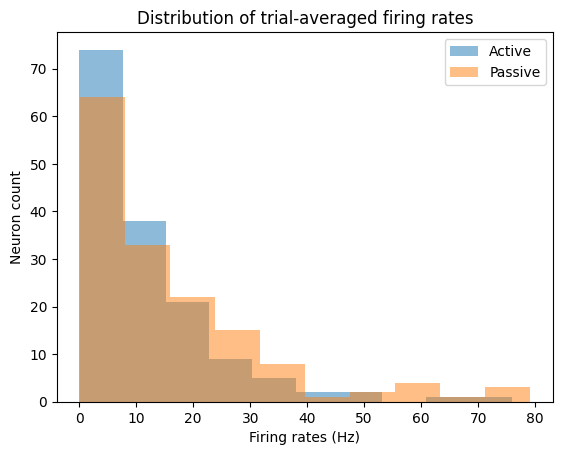

In [62]:
plt.hist(np.mean(active_spikes_resampled,axis = 0),alpha  =0.5, label = 'Active')
plt.hist(np.mean(passive_spikes_resampled,axis = 0),alpha = 0.5,label = 'Passive')
plt.xlabel('Firing rates (Hz)')
plt.ylabel('Neuron count')
plt.legend()
plt.title('Distribution of trial-averaged firing rates')

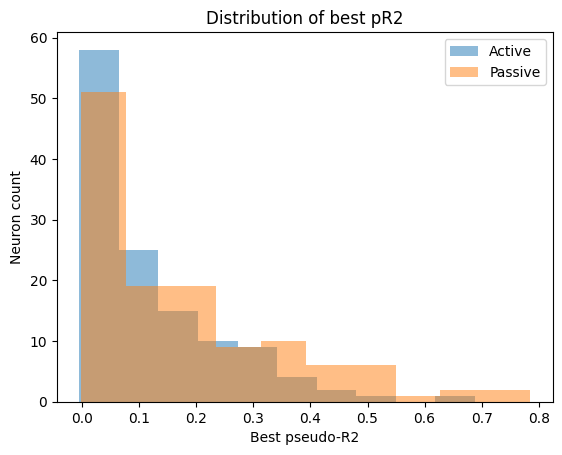

In [63]:
active_r2s = np.nanmax(active_pR2,axis = 0) #highest pr2 in active condition that encode all neurons
passive_r2s = np.nanmax(passive_pR2,axis = 0) #pasisve condition
plt.hist(active_r2s,alpha = 0.5,label = 'Active')
plt.hist(passive_r2s,alpha = 0.5,label = 'Passive')
plt.xlabel("Best pseudo-R2")
plt.ylabel("Neuron count")
plt.title('Distribution of best pR2')
plt.legend()

[ModeResult(mode=array([120]), count=array([26])), ModeResult(mode=array([40]), count=array([42]))]


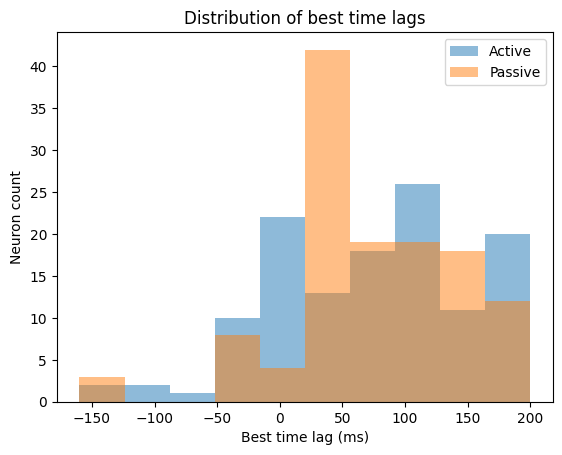

In [70]:
active_lags = lag_range[np.argmax(active_pR2,axis = 0)] #best time lags in active condition that encode all neurons
passive_lags = lag_range[np.argmax(passive_pR2,axis = 0)] #pasisve condition
plt.hist(active_lags,alpha = 0.5,label = 'Active')
plt.hist(passive_lags,alpha = 0.5,label = 'Passive')
plt.xlabel("Best time lag (ms)")
plt.ylabel("Neuron count")
plt.title('Distribution of best time lags')
plt.legend()
print([stats.mode(active_lags), stats.mode(passive_lags)])

In [67]:
# active_lags = []
# passive_lags = []
# active_r2s = []
# passive_r2s = []
# for i in range(n_high_neurons):
#     active = active_pR2[:,i]
#     passive = passive_pR2[:,i]
#     if np.nanmax(active) >= 0.2 and np.nanmax(passive) >= 0.2:
#         active_r2s.append(np.nanmax(active))
#         passive_r2s.append(np.nanmax(passive))        
#         active_lags.append(lag_range[np.argmax(active_pR2[:,i])])
#         passive_lags.append(lag_range[np.argmax(passive_pR2[:,i])])

In [65]:
active_lags_rand = np.add(active_lags, np.random.uniform(low=-10, high=10, size=(len(active_lags),)))
passive_lags_rand = np.add(passive_lags, np.random.uniform(low=-10, high=10, size=(len(passive_lags),)))

[78.4, 79.68]


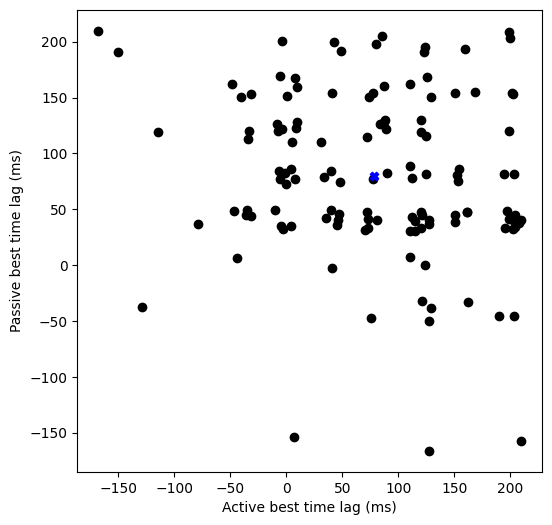

In [71]:
plt.figure(figsize=(6,6))
# plt.xlim(-220, 220)
# plt.ylim(-220, 220)
plt.ylabel("Passive best time lag (ms)")
plt.xlabel("Active best time lag (ms)")
plt.scatter(active_lags_rand, passive_lags_rand,color = 'k')

plt.scatter(np.mean(active_lags), np.mean(passive_lags), marker = 'X', color = 'blue')
print([np.mean(active_lags),np.mean(passive_lags)])

[0.1178766027468435, 0.177584029576321]


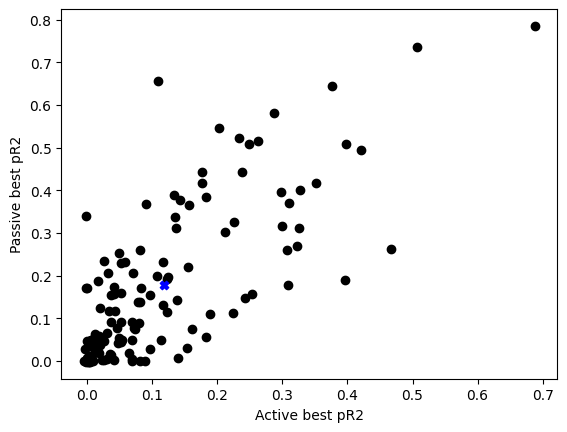

In [69]:
# plt.xlim(-0.2, 1)
# plt.ylim(-15, 1)
plt.ylabel("Passive best pR2")
plt.xlabel("Active best pR2")
plt.scatter(active_r2s, passive_r2s,color = 'k')

plt.scatter(np.mean(active_r2s), np.mean(passive_r2s), marker = 'X', color = 'blue')
print([np.mean(active_r2s),np.mean(passive_r2s)])